<a href="https://colab.research.google.com/github/CyberIngeniero/Proyecto_Clustering_HDI/blob/master/clusters_mm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{forestgreen}{\underline{\text{Proyecto Nuevos Clusters para Vehículos - Version Final}}}
$

# Preliminares

## Memory Information

In [ ]:
import psutil

def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
        
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.96GB
Used: 509.10MB
Percentage: 5.9%


## GPU Information

In [ ]:
! nvidia-smi

Wed Nov  4 19:03:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Conexion con Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Importa Modulos de Funciones Ancilares

In [2]:
import os
path = "/tmp/data_clusters"
os.mkdir(path)

## Importando Modulo de Funciones Ancilares

In [3]:
!cp  /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/func_ancilares.py /tmp/data_clusters

## Copia de datos a entorno local

In [4]:
# Copia del archivo a directorio local
!cp  /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/Clustering_22_09_2020.csv /tmp/data_clusters

# Moviendo datos a entorno de trabajo
os.rename("/tmp/data_clusters/Clustering_22_09_2020.csv", "/tmp/data_clusters/Base_Clusters_MM.csv")

## Estableciendo Workspace

In [5]:
# Cambiando a directorio de trabajo
os.chdir(path)
print(os.getcwd())

/tmp/data_clusters


## Librerias

In [6]:
import func_ancilares as fxlib

import shutil
import sys
import math

import pandas as pd

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.impute import SimpleImputer

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials #Bayesiano

import pydotplus
from sklearn.tree import export_graphviz

import pickle # Serialización de Modelos

import missingno as msno

from IPython.display import display, Markdown, Image

import warnings
warnings.filterwarnings("ignore")

# Carga y Lectura de Registros

## Data Import

In [7]:
df = fxlib.data_import("Base_Clusters_MM.csv")

,rut_num,antiguedad_veh,dia_precot,sisgen_usar,mod_tasacion_fiscal,precot_veh_modelo_id,canal_producto,precot_veh_tipo_id,precot_veh_tipo,precot_veh_uso,precot_veh_uso_id,numero_semana,edad,cotizacion,venta,santander,week enddate,tasa_conversion
0,24855954.0,0,25,0.85,4.0,285024,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,5,Extranjero,7,1,0.0,01-03-2020,"100,00%"
1,16173686.0,0,25,0.85,7.0,521020,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,5,34,6,1,0.0,01-03-2020,"100,00%"
2,14183913.0,0,6,0.85,20.0,110009,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,2,40,5,1,0.0,08-12-2019,"100,00%"
3,23418340.0,0,2,0.85,4.0,285024,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,2,Extranjero,4,1,0.0,07-04-2019,"100,00%"
4,18885743.0,0,24,0.85,8.0,285022,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,5,25,4,1,0.0,28-04-2019,"100,00%"


# Data Treatment

## Información General

In [8]:
# Información de la data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983239 entries, 0 to 983238
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rut_num               983207 non-null  float64
 1   antiguedad_veh        983239 non-null  int64  
 2   dia_precot            983239 non-null  int64  
 3   sisgen_usar           983239 non-null  float64
 4   mod_tasacion_fiscal   978799 non-null  float64
 5   precot_veh_modelo_id  983239 non-null  int64  
 6   canal_producto        983239 non-null  object 
 7   precot_veh_tipo_id    983239 non-null  int64  
 8   precot_veh_tipo       983239 non-null  object 
 9   precot_veh_uso        983239 non-null  object 
 10  precot_veh_uso_id     983239 non-null  int64  
 11  numero_semana         983239 non-null  int64  
 12  edad                  983239 non-null  object 
 13  cotizacion            983239 non-null  int64  
 14  venta                 983239 non-null  int64  
 15  

## Analisis de Datos Perdidos

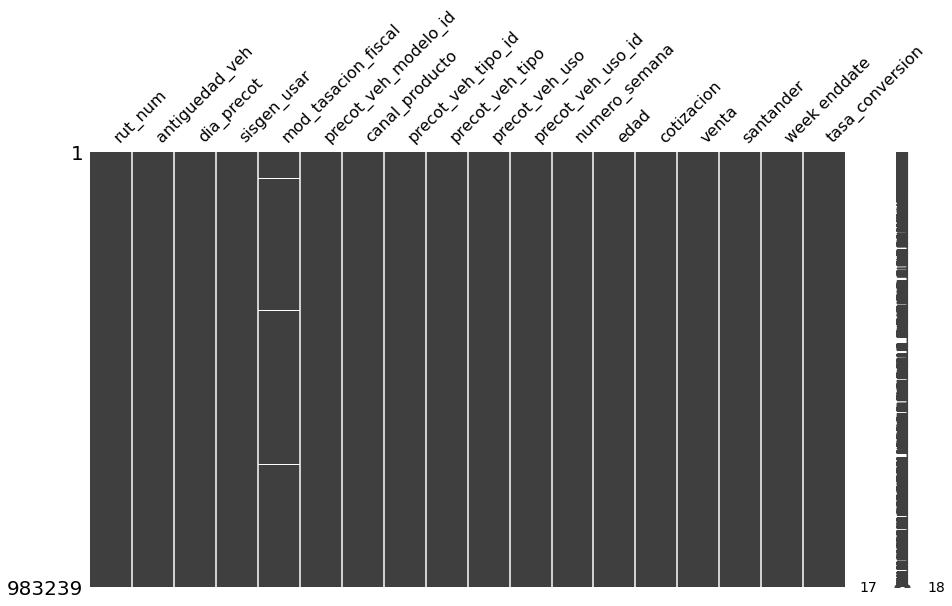

In [9]:
# Analisis de Datos Perdidos
msno.matrix(df, figsize=(15,8));

In [10]:
# Conteo de Registros NUlos
fxlib.print_nulls(df)

Valores Nulos por Columna 



rut_num                   32
antiguedad_veh             0
dia_precot                 0
sisgen_usar                0
mod_tasacion_fiscal     4440
precot_veh_modelo_id       0
canal_producto             0
precot_veh_tipo_id         0
precot_veh_tipo            0
precot_veh_uso             0
precot_veh_uso_id          0
numero_semana              0
edad                       0
cotizacion                 0
venta                      0
santander                  0
week enddate               0
tasa_conversion            0
dtype: int64

__COMENTARIOS__
 - Para favorecer el análsis, los registros nulos será imputados por la media de cada columna.

## Imputación de Missing data y Ajustes de Variables

In [11]:
# Ajuste de Variables
fxlib.fixed_var(df)

## Análisis Univariado

In [12]:
df.describe()

,antiguedad_veh,dia_precot,sisgen_usar,mod_tasacion_fiscal,precot_veh_tipo_id,precot_veh_uso_id,numero_semana,edad,cotizacion
count,983239.000000,983239.000000,983239.000000,983239.000000,983239.000000,983239.000000,983239.000000,983239.000000,983239.000000
mean,2.911086,15.842948,0.893344,12.136763,1.992929,1.976169,3.343021,41.351467,1.006942
std,3.331797,8.657400,0.105182,6.450133,1.936390,9.625589,1.308886,16.525442,0.084584
min,0.000000,1.000000,0.850000,2.000000,1.000000,1.000000,1.000000,-2.000000,1.000000
25%,0.000000,9.000000,0.850000,8.000000,1.000000,1.000000,2.000000,32.000000,1.000000
50%,2.000000,16.000000,0.850000,10.000000,1.000000,1.000000,3.000000,42.000000,1.000000
75%,5.000000,23.000000,0.870000,15.000000,1.000000,1.000000,4.000000,54.000000,1.000000
max,19.000000,31.000000,1.500000,111.000000,11.000000,99.000000,6.000000,86.000000,7.000000


## Análisis Univariado Gráfico

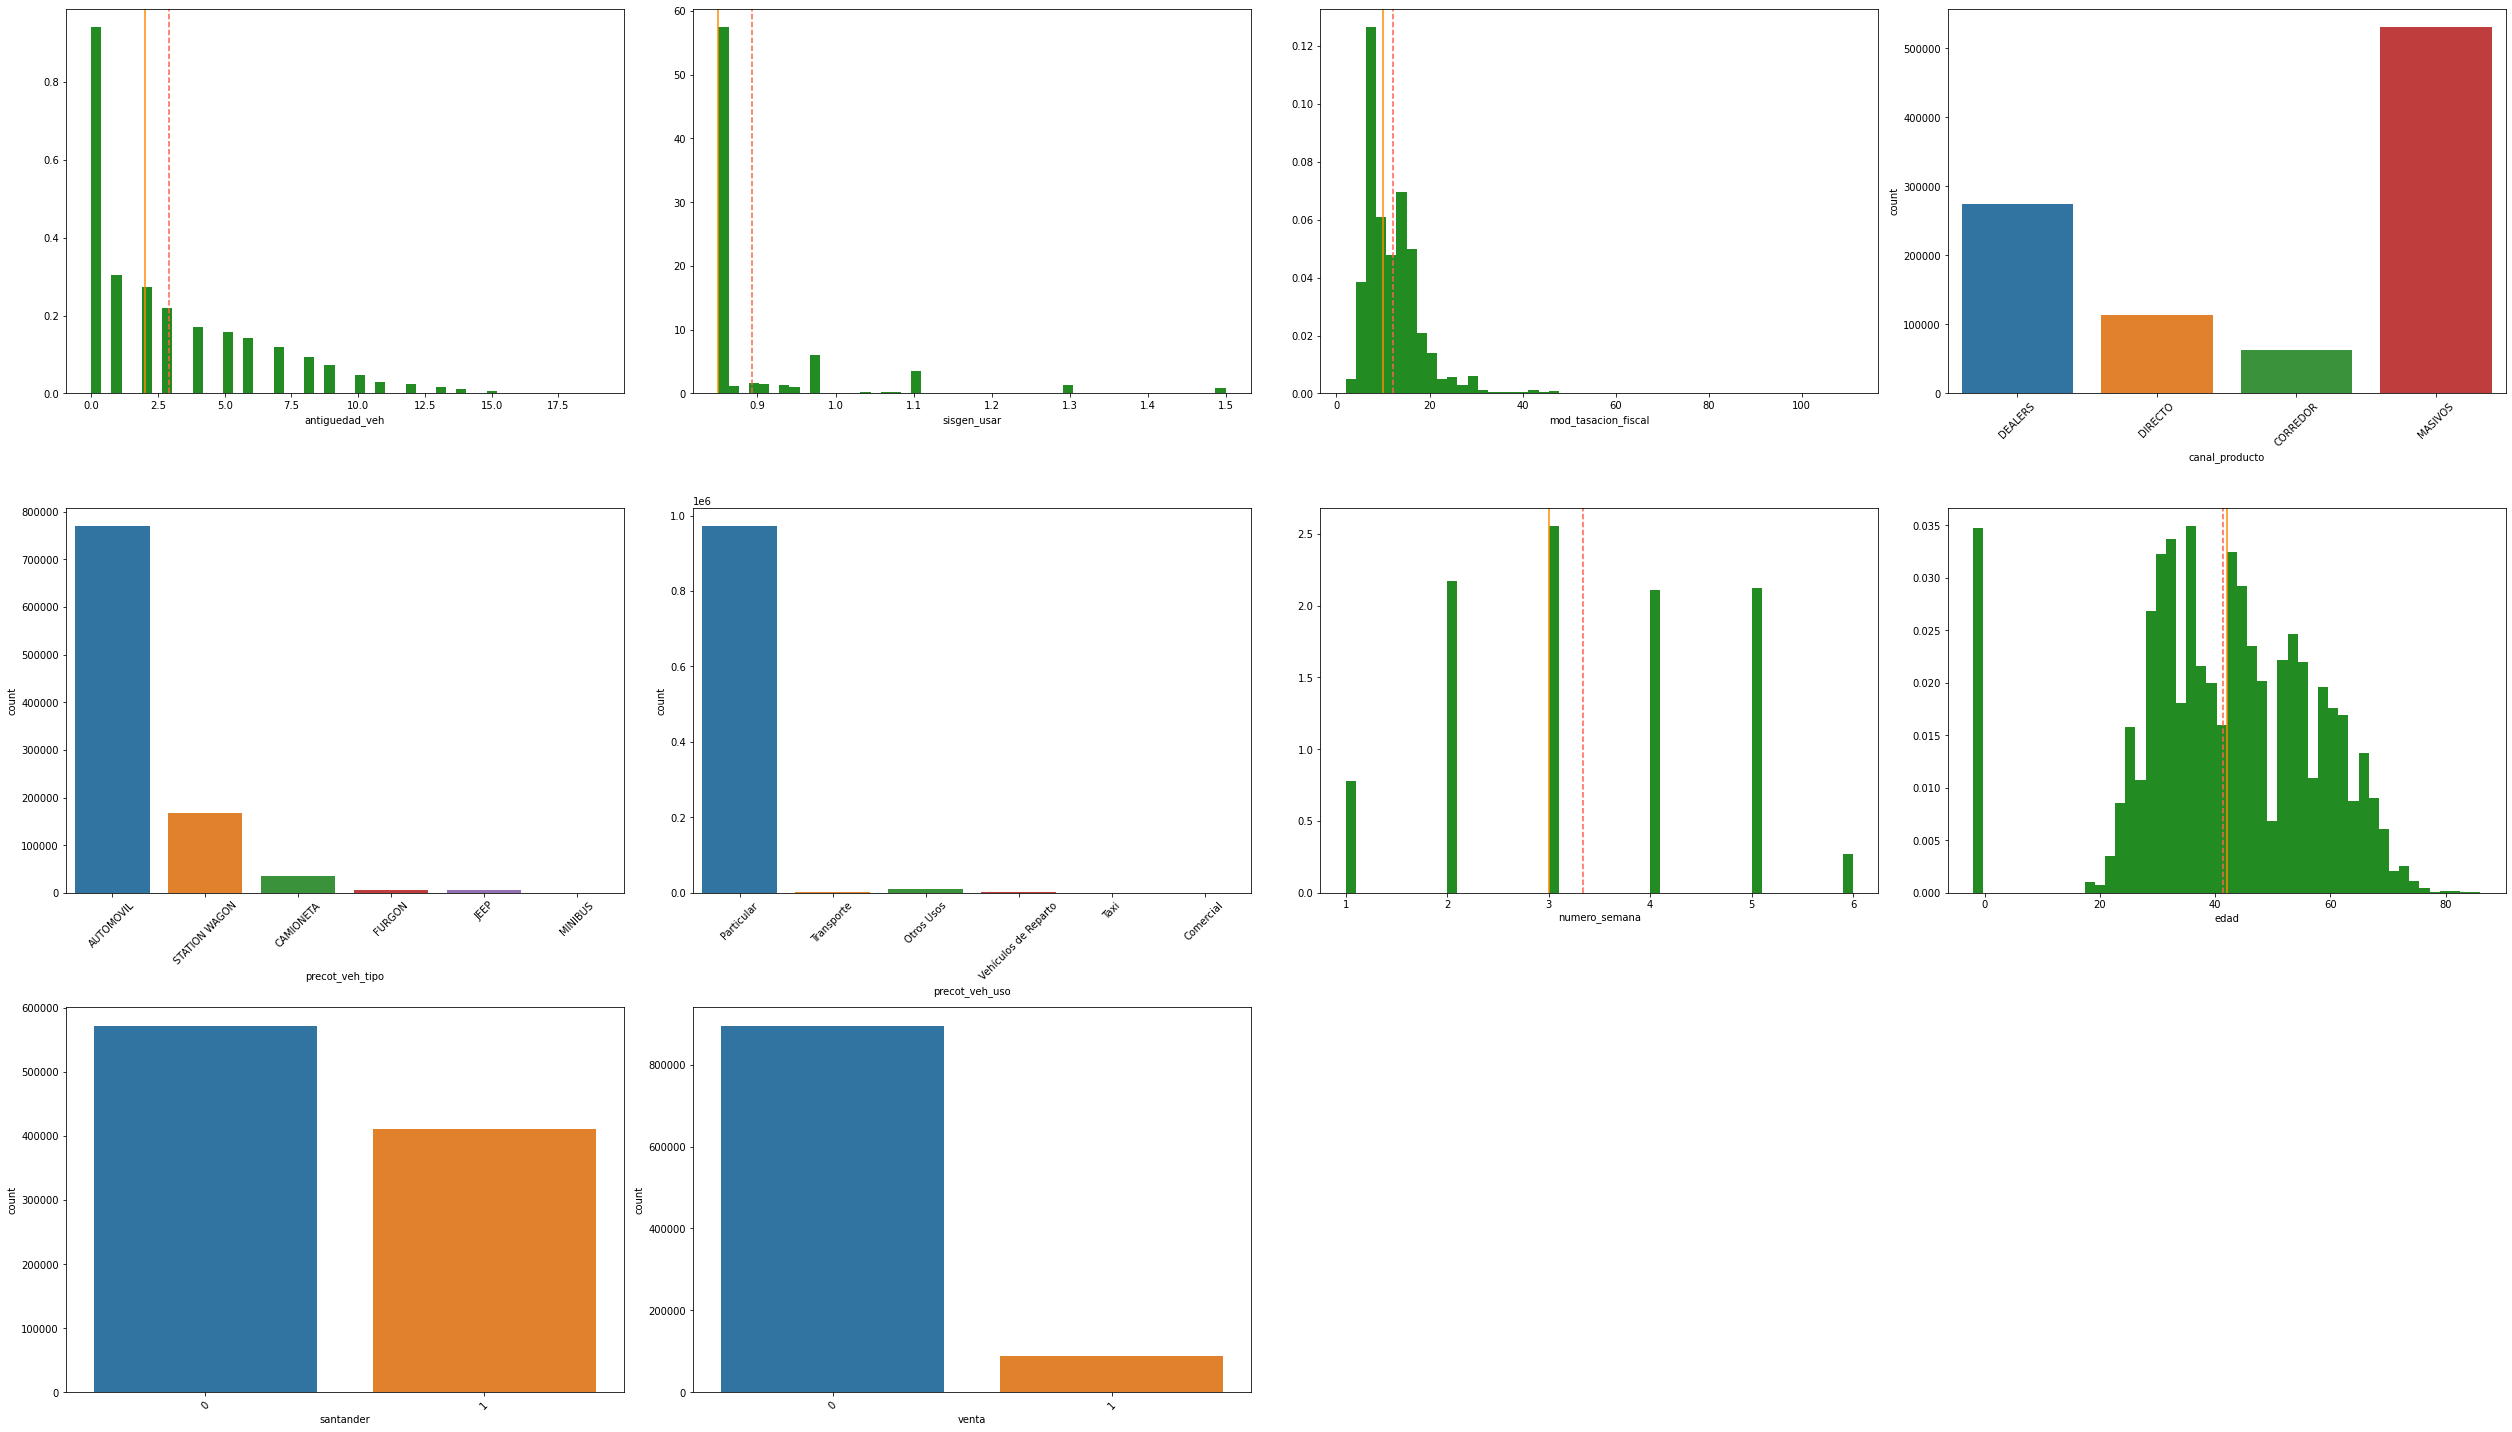

In [13]:
# Analisis Univariado
variables = ['antiguedad_veh', 'sisgen_usar', 'mod_tasacion_fiscal', 
             'canal_producto', 'precot_veh_tipo', 'precot_veh_uso', 
             'numero_semana', 'edad', 'santander', 'venta']

fxlib.univariate_plot(df, variables, 3, 4)

__Comentarios__
- Se sugiere realizar agrupaciones en las variables `edad` y `antiguedad_veh`.
- La variable objetivo `venta` se muestra desbalanceada, lo que será tratado más adelante.

## Grouping Data

In [14]:
fxlib.group_data(df)

__Comentario__
- Para agrupar las variables `edad`, `antiguedad_veh` Y  `sisgen_usar` se utilizo como criterio las agrupaciones existentes hoy en día en el modelo de vehiculos vigente.

### Grouping Inspection

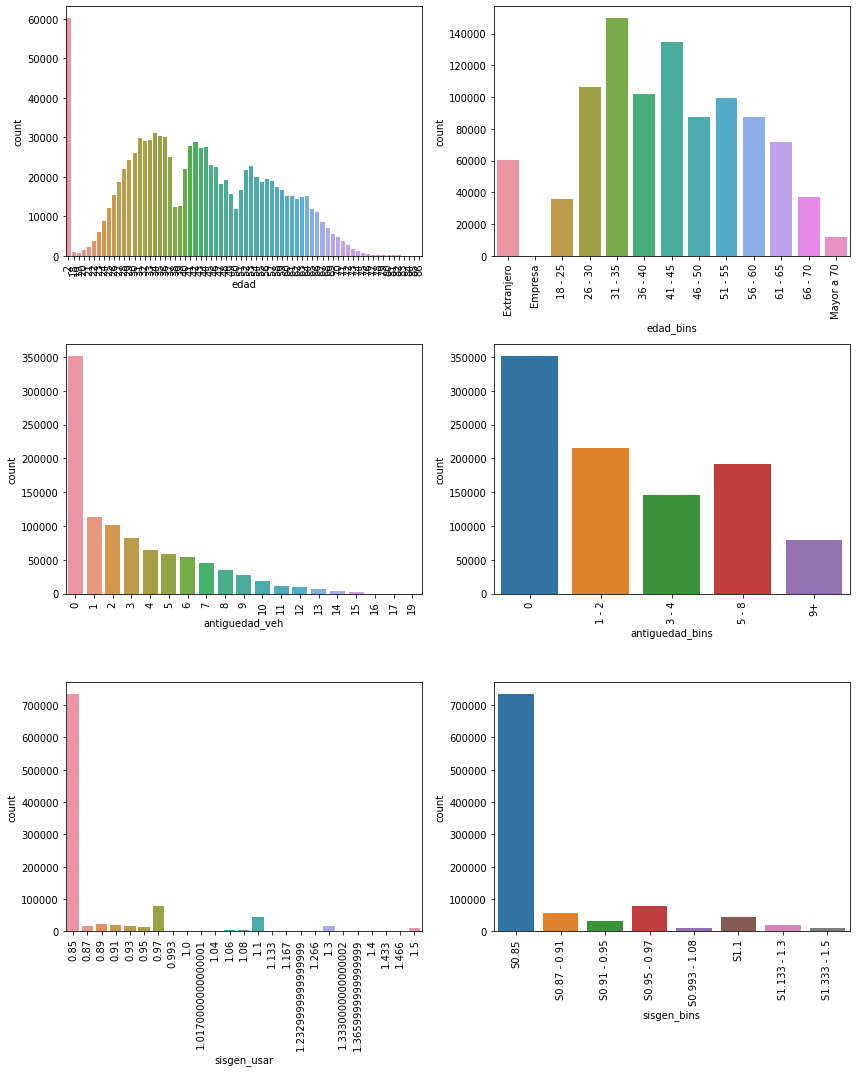

In [15]:
variables = ['edad', 'edad_bins', 'antiguedad_veh', 'antiguedad_bins', 'sisgen_usar', 'sisgen_bins']

fxlib.comparison_grouping_data(df, variables, 3, 2)

## Análisis Variable Objetivo: `venta`

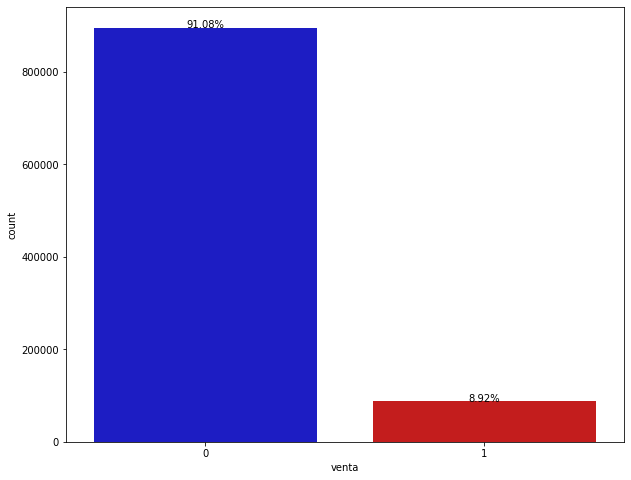

In [16]:
fxlib.target_plot(df, 'venta')

### Variable Objetivo Filtrando Santander

In [17]:
# se filtran registros que no corresponden a santander
df_filter = df[df['santander'] == 0]

print('data original: ', df.shape)
print('data sin santander: ', df_filter.shape)

data original:  (983239, 21)
data sin santander:  (572204, 21)


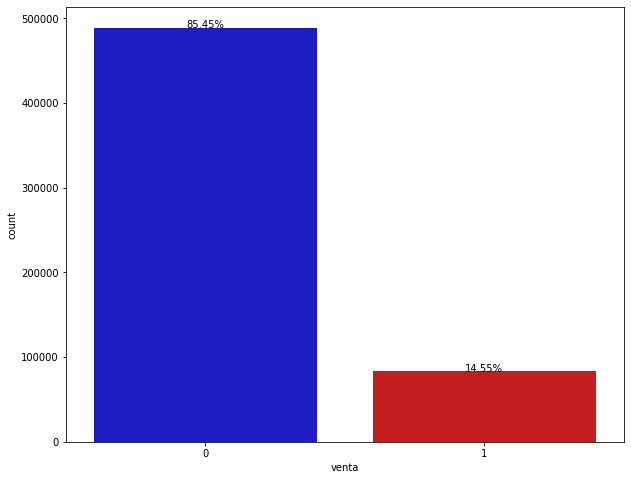

In [18]:
fxlib.target_plot(df_filter, 'venta')

# Análisis de Correlaciones

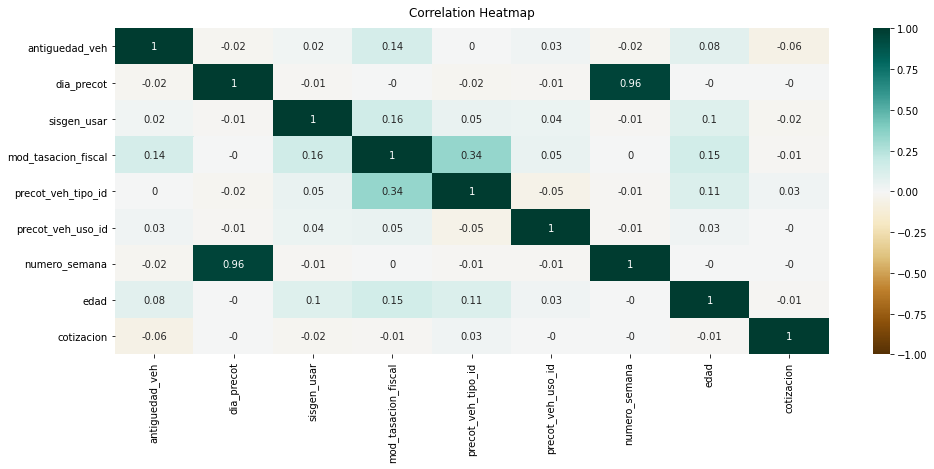

In [19]:
# Analisis de Correlación
plt.figure(figsize=(16, 6))
ax = sns.heatmap(df_filter.corr().round(2), annot=True, vmin=-1, vmax=1, cmap= 'BrBG')
ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Categorical Encoding

In [20]:
cols = ['edad_bins', 'antiguedad_bins', 'sisgen_bins','precot_veh_modelo_id']
fxlib.categorical_encoding(df_filter, cols)

# Copias de datos para Modelación

In [147]:
# Copia de registros a modelar
data_model_1 = df_filter.copy()
data_model_3 = df_filter.copy()

In [148]:
def var_type(df, col_list):
    for i in col_list:
        df[i] = df[i].astype('object')

In [149]:
var_type(data_model_3, col_list = ['canal_code','precot_veh_modelo_id_code','precot_veh_tipo_id','dia_precot','antiguedad_veh','venta'])

# Modelacion

## Filtro y Split Data

In [150]:
# Borrando variables que no se usaran
data_model_3.drop(columns = ['rut_num', 'antiguedad_bins_code', 'sisgen_bins_code',
                             'precot_veh_tipo', 'precot_veh_uso', 'numero_semana', 
                             'edad', 'cotizacion', 'santander', 'week enddate', 
                             'tasa_conversion', 'edad_bins_code','precot_veh_uso_id'],
                 inplace = True)

# Genera data de train y test
data_train, data_test = train_test_split(data_model_3, test_size=.3, stratify = data_model_3['venta'], random_state = 0)

## Variable Objetivo - Venta

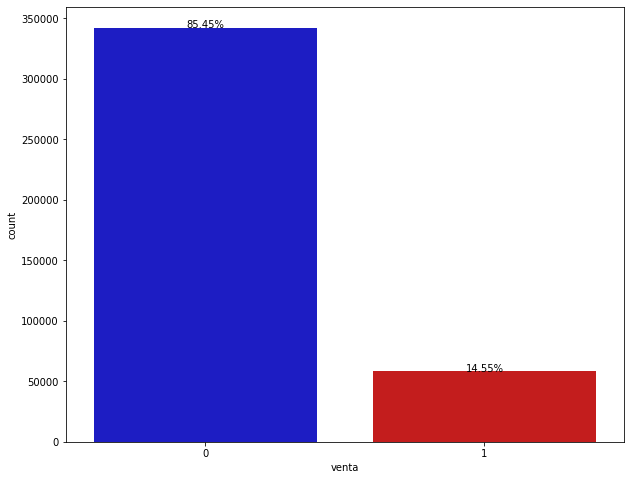

In [151]:
fxlib.target_plot(data_train, 'venta')

## Control del Desbalance: Remuestreo 70-30

In [152]:
sub_sample = fxlib.subsampling(data_train, 'venta', 0.3)

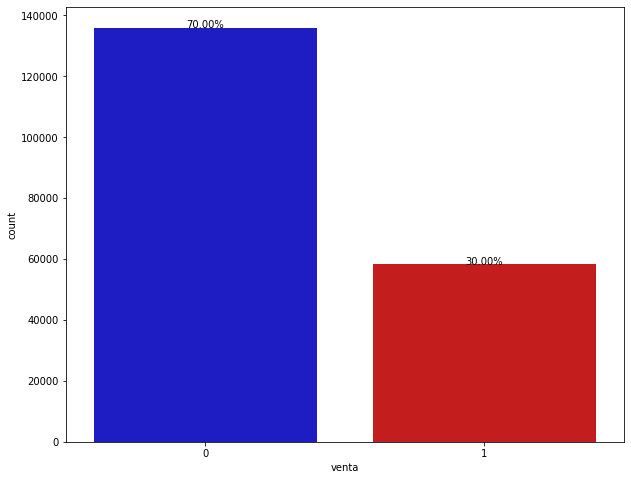

In [153]:
fxlib.target_plot(sub_sample, 'venta')

## Separando Vector Objetivo y Matriz de Diseño

In [154]:
# Separando X e y para train & test
X_train = sub_sample.drop(columns = ['venta'])
y_train = sub_sample['venta'].astype(int)

X_test = data_test.drop(columns = ['venta'])
y_test = data_test['venta'].astype(int)

# Desicion Tree Clasiffier

## Optimización de Hiperparametros

In [155]:
tree_grid = fxlib.tree_hyperparameters_tuning(X_train, y_train)

print('Mejor score: ', tree_grid.best_score_)
print('Mejores Parametros: ', tree_grid.best_params_)

Mejor score:  0.7213998378608937
Mejores Parametros:  {'criterion': 'entropy', 'max_depth': 11}


## Grafico de Desempeño

In [ ]:
fxlib.perfonmance_plot(X_train, y_train)

## Ajuste y Predicciones del modelo

In [156]:
 dec_tree, y_train_pred, \
y_train_proba, y_test_pred, y_test_proba = fxlib.fit_model_tree(X_train, y_train, X_test, tree_grid)

## Serializacion del Modelo

```python
# Serialización del modelo
pickle.dump(dec_tree, open('dec_tree_model.pkl','wb'))
 
# Copia del modelo serializado a carpeta drive
!cp /tmp/data_clusters/dec_tree_model.pkl /gdrive/My\ Drive/Proyecto_Nuevos_Clusters
```

In [ ]:
# Copia del archivo a directorio local
!cp /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/dec_tree_model.pkl /tmp/data_clusters

# importación modelo para mostrar métricas
dec_tree = pickle.load(open('dec_tree_model.pkl', 'rb'))

## Features Importances

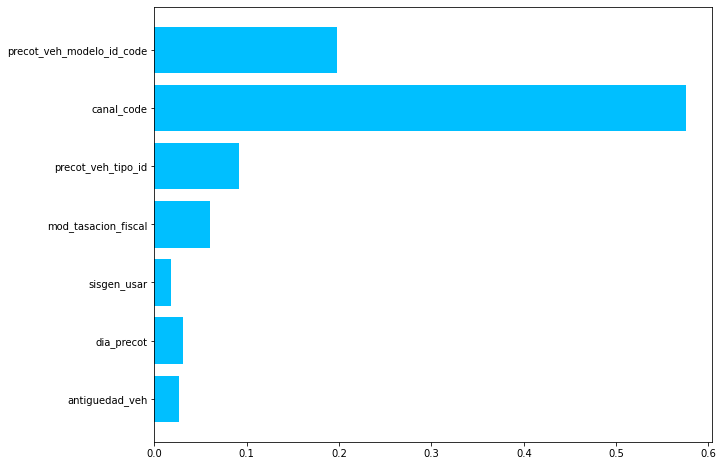

In [157]:
fxlib.features_importances_plot(dec_tree, X_train.columns)

### Predicciones del Modelo Ajustado

```python
# Train Predict
y_train_pred_m2 = dec_tree.predict(X_train)
y_train_proba_m2 = dec_tree.predict_proba(X_train)

# Test Predict
y_test_pred_m2 = dec_tree.predict(X_test)
y_test_proba_m2 = dec_tree.predict_proba(X_test)
```

## Metricas del Modelo

----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.640433 
Recall: 0.562895 
F1: 0.599165
AUC:  0.7137255212497183

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,117584,18421
Falso,25478,32810


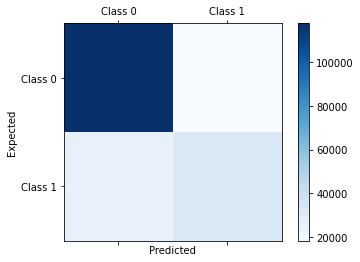


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.821909,0.640433,0.774058,0.731171,0.767466
recall,0.864556,0.562895,0.774058,0.713726,0.774058
f1-score,0.842694,0.599165,0.774058,0.720930,0.769635
support,136005.000000,58288.000000,0.774058,194293.000000,194293.000000



 ROC CURVE MODEL


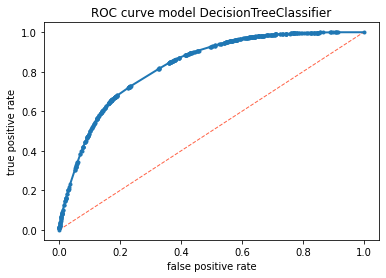


 PRECISION-RECALL CURVE


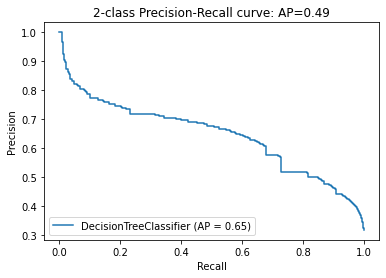


 TRADE-OFF PRECISION RECALL - TRAINING SET


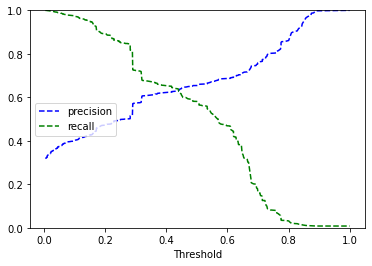


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.413803 
Recall: 0.557784 
F1: 0.475125
AUC:  0.71160648805891

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,126942,19739
Falso,11047,13934


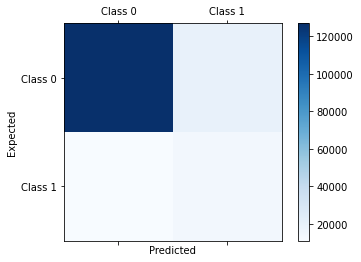


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.919943,0.413803,0.820659,0.666873,0.846287
recall,0.865429,0.557784,0.820659,0.711606,0.820659
f1-score,0.891854,0.475125,0.820659,0.683490,0.831210
support,146681.000000,24981.000000,0.820659,171662.000000,171662.000000



 ROC CURVE MODEL


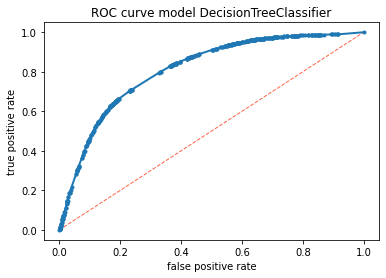


 PRECISION-RECALL CURVE


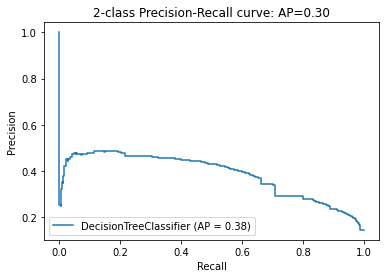


 TRADE-OFF PRECISION RECALL - TESTING SET


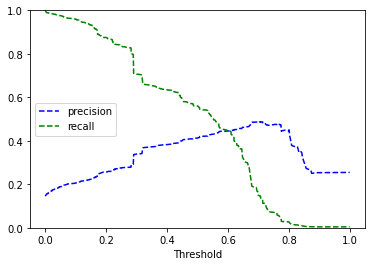

In [158]:
fxlib.metrics_report(dec_tree, X_train, y_train, X_test, y_test)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.643603 
Recall: 0.666249 
F1: 0.654731
AUC:  0.6758816997623234

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,39197,17982
Falso,16267,32473


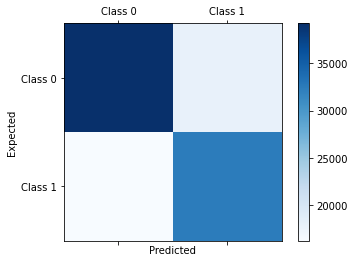


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.706711,0.643603,0.676649,0.675157,0.677671
recall,0.685514,0.666249,0.676649,0.675882,0.676649
f1-score,0.695951,0.654731,0.676649,0.675341,0.676983
support,57179.000000,48740.000000,0.676649,105919.000000,105919.000000



 ROC CURVE MODEL


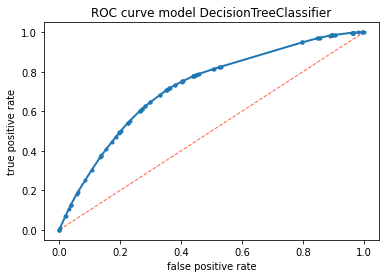


 PRECISION-RECALL CURVE


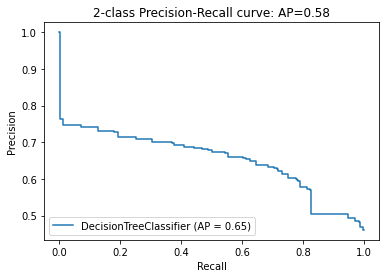


 TRADE-OFF PRECISION RECALL - TRAINING SET


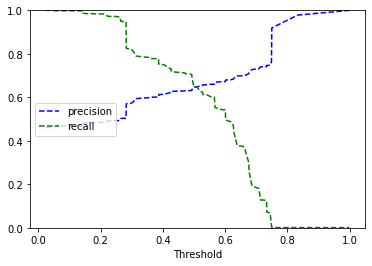


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.418436 
Recall: 0.637793 
F1: 0.505336
AUC:  0.6686136889789062

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,43032,18492
Falso,7556,13305


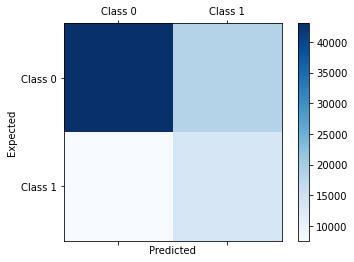


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.850637,0.418436,0.683826,0.634536,0.741197
recall,0.699434,0.637793,0.683826,0.668614,0.683826
f1-score,0.767661,0.505336,0.683826,0.636499,0.701237
support,61524.000000,20861.000000,0.683826,82385.000000,82385.000000



 ROC CURVE MODEL


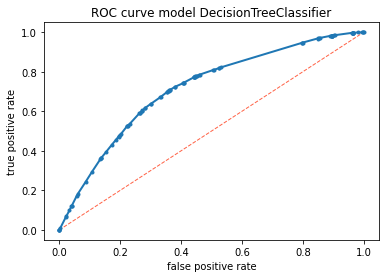


 PRECISION-RECALL CURVE


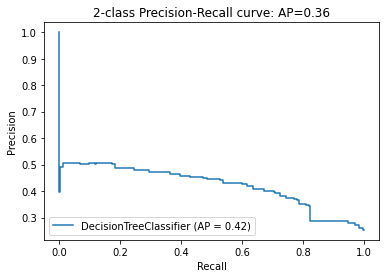


 TRADE-OFF PRECISION RECALL - TESTING SET


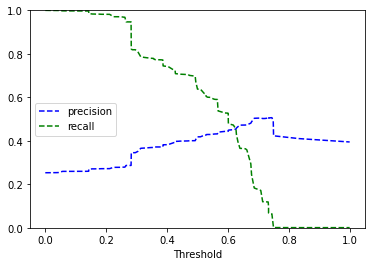

In [32]:
fxlib.canal_report(dec_tree, 1, X_train, y_train, X_test, y_test)

### Canal Directo

----------------------------------------------------------------------------
CANAL DIRECTO
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.255172 
Recall: 0.005308 
F1: 0.010399
AUC:  0.500795371494998

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,28948,108
Falso,6934,37


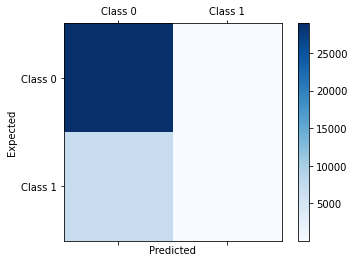


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.806755,0.255172,0.804535,0.530964,0.700028
recall,0.996283,0.005308,0.804535,0.500795,0.804535
f1-score,0.891558,0.010399,0.804535,0.450979,0.721059
support,29056.000000,6971.000000,0.804535,36027.000000,36027.000000



 ROC CURVE MODEL


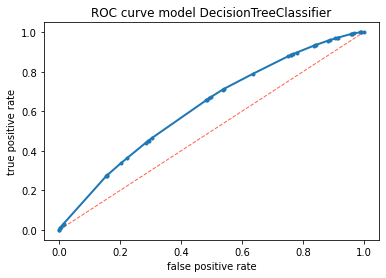


 PRECISION-RECALL CURVE


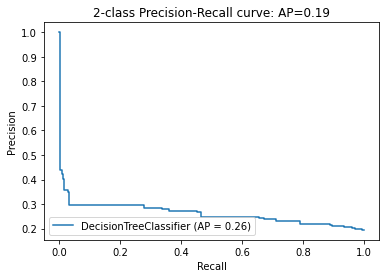


 TRADE-OFF PRECISION RECALL - TRAINING SET


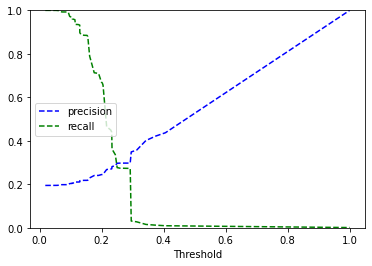


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.4999200869454034

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,31279,5
Falso,3006,0


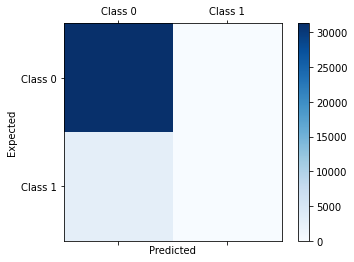


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.912323,0.0,0.91219,0.456162,0.832345
recall,0.999840,0.0,0.91219,0.499920,0.912190
f1-score,0.954079,0.0,0.91219,0.477039,0.870440
support,31284.000000,3006.0,0.91219,34290.000000,34290.000000



 ROC CURVE MODEL


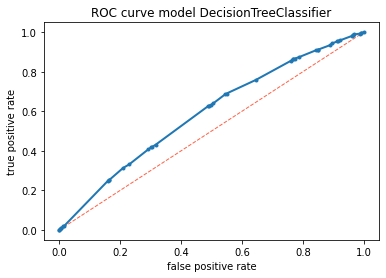


 PRECISION-RECALL CURVE


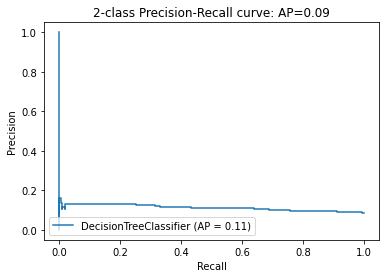


 TRADE-OFF PRECISION RECALL - TESTING SET


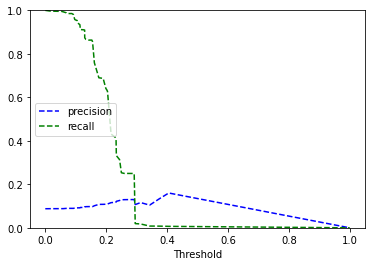

In [33]:
fxlib.canal_report(dec_tree, 2, X_train, y_train, X_test, y_test)

### Canal Masivos

----------------------------------------------------------------------------
CANAL MASIVOS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.200000 
Recall: 0.006972 
F1: 0.013474
AUC:  0.503061298495339

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,32932,28
Falso,997,7


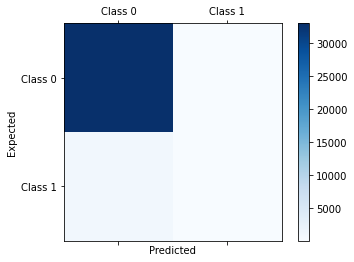


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.970615,0.200000,0.969821,0.585308,0.947835
recall,0.999150,0.006972,0.969821,0.503061,0.969821
f1-score,0.984676,0.013474,0.969821,0.499075,0.955967
support,32960.000000,1004.000000,0.969821,33964.000000,33964.000000



 ROC CURVE MODEL


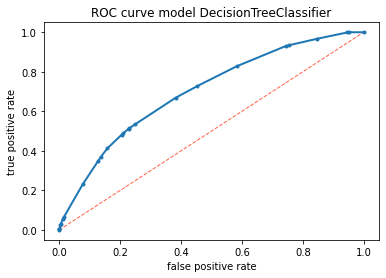


 PRECISION-RECALL CURVE


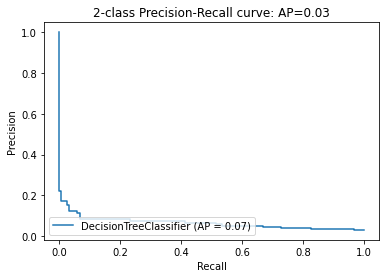


 TRADE-OFF PRECISION RECALL - TRAINING SET


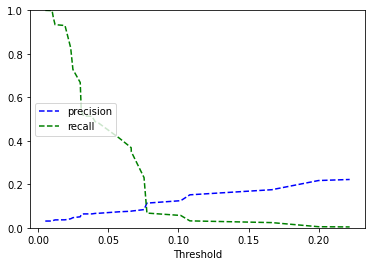


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,35545,0
Falso,454,0


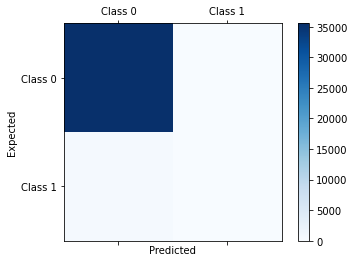


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.987389,0.0,0.987389,0.493694,0.974936
recall,1.000000,0.0,0.987389,0.500000,0.987389
f1-score,0.993654,0.0,0.987389,0.496827,0.981123
support,35545.000000,454.0,0.987389,35999.000000,35999.000000



 ROC CURVE MODEL


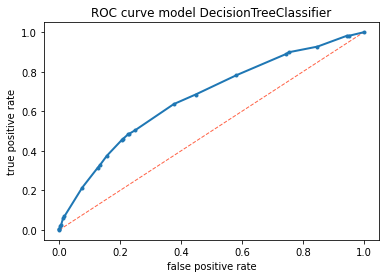


 PRECISION-RECALL CURVE


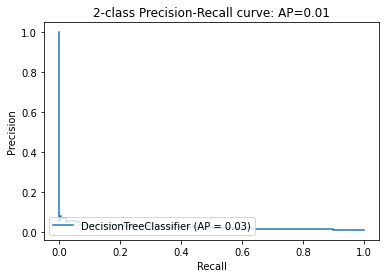


 TRADE-OFF PRECISION RECALL - TESTING SET


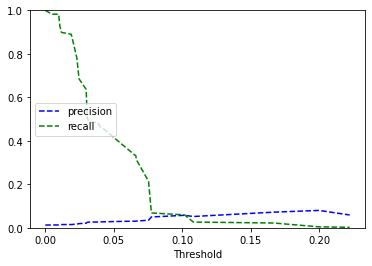

In [34]:
fxlib.canal_report(dec_tree, 3, X_train, y_train, X_test, y_test)

### Canal Corredor

----------------------------------------------------------------------------
CANAL CORREDOR
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.191781 
Recall: 0.008900 
F1: 0.017011
AUC:  0.5026951875662059

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,16751,59
Falso,1559,14


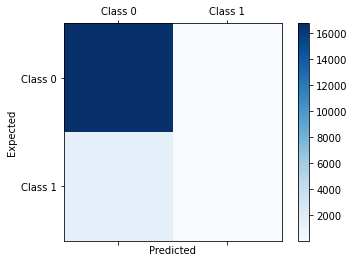


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.914855,0.191781,0.911984,0.553318,0.852983
recall,0.996490,0.008900,0.911984,0.502695,0.911984
f1-score,0.953929,0.017011,0.911984,0.485470,0.873759
support,16810.000000,1573.000000,0.911984,18383.000000,18383.000000



 ROC CURVE MODEL


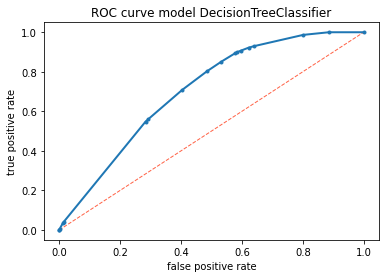


 PRECISION-RECALL CURVE


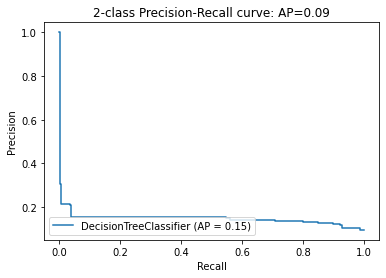


 TRADE-OFF PRECISION RECALL - TRAINING SET


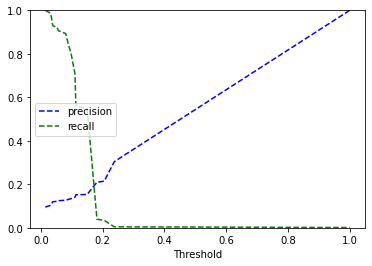


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.49997271933653425

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,18327,1
Falso,660,0


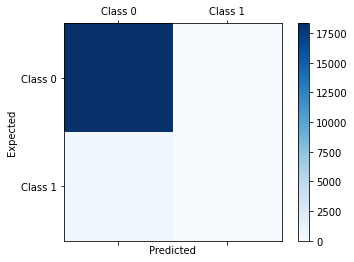


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.965239,0.0,0.965189,0.482620,0.931689
recall,0.999945,0.0,0.965189,0.499973,0.965189
f1-score,0.982286,0.0,0.965189,0.491143,0.948143
support,18328.000000,660.0,0.965189,18988.000000,18988.000000



 ROC CURVE MODEL


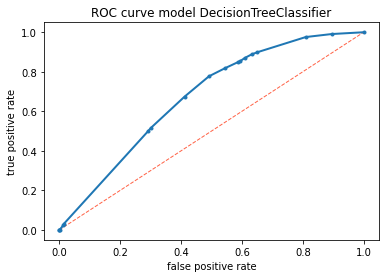


 PRECISION-RECALL CURVE


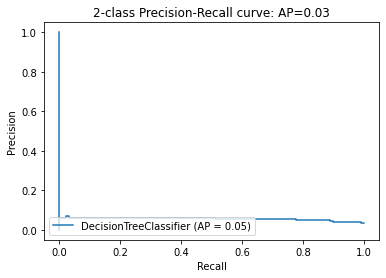


 TRADE-OFF PRECISION RECALL - TESTING SET


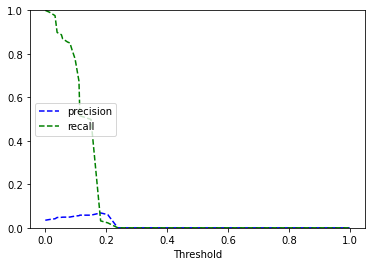

In [35]:
fxlib.canal_report(dec_tree, 4, X_train, y_train, X_test, y_test)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.675882,0.500795,0.503061,0.502695
Accuracy,0.676650,0.804540,0.969820,0.911980
Presicion,0.675160,0.530960,0.585310,0.553320
Recall,0.675880,0.500800,0.503060,0.502700
F1,0.675340,0.450980,0.499080,0.485470


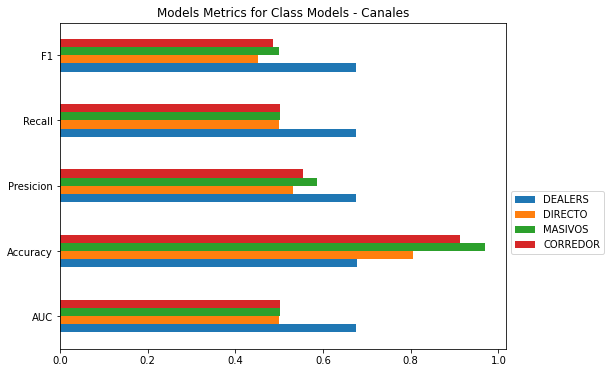

In [36]:
fxlib.canal_comparison(dec_tree, X_train, y_train)

### Comparación Test dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.542537,0.499575,0.500679,0.50013
Accuracy,0.748850,0.911290,0.986580,0.96408
Presicion,0.640420,0.469290,0.509830,0.50346
Recall,0.542540,0.499570,0.500680,0.50013
F1,0.525870,0.477120,0.498680,0.49232


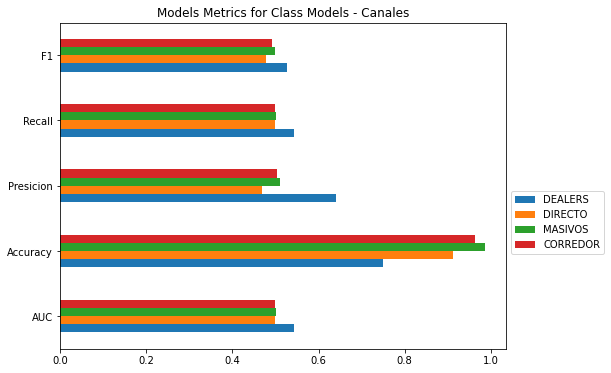

In [37]:
fxlib.canal_comparison(dec_tree, X_test, y_test)

# XGBoost

### Diseño del Espacio Parametrico

In [38]:
# Parametric Space
space = {'objective':'binary:logistic',
         'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform ('gamma', 1,9),
         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 180,
         'seed': 16626
         }         

### Definición de Función de Optimización

In [41]:
def objective(space):
    clf = xgb.XGBClassifier(objective = space['objective'],
                            n_estimators = space['n_estimators'], 
                            max_depth = int(space['max_depth']), 
                            gamma = space['gamma'],
                            reg_alpha = int(space['reg_alpha']),
                            min_child_weight = int(space['min_child_weight']),
                            colsample_bytree=int(space['colsample_bytree']))
                            #tree_method='gpu_hist')
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set = evaluation, 
            eval_metric = "auc",
            early_stopping_rounds = 10,
            verbose = False)
    

    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred>0.5, average='binary')
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }  

### Optimización Bayesiana de Hyperparametros

In [42]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.4624421900641503
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.4622627465574991
SCORE:
0.0
SCORE:
0.0
SCORE:
0.45708994009033693
SCORE:
0.0
SCORE:
0.0
SCORE:
0.4635840297121634
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.4577460813277383
SCORE:
0.0
SCORE:
0.46523145153839046
SCORE:
0.4660047525190193
SCORE:
0.4656917054435335
SCORE:
0.4655375987012029
SCORE:
0.46620227038183704
SCORE:
0.0
SCORE:
0.46622257487129337
SCORE:
0.4644984136996976
SCORE:
0.465768612450801
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.46299154039230267
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.4627452441728308
SCORE:
0.0
SCORE:
0.46700227823914164
SCORE:
0.0
SCORE:
0.46589588980472424
SCORE:
0.45824854925013186
SCORE:
0.0
SCORE:
0.4641152767719533
SCORE:
0.0
SCORE:
0.0
SCORE:
0.0
SCORE:
0.46632334754600663

In [43]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.927886216342132, 'gamma': 1.302813660709833, 'max_depth': 12.0, 'min_child_weight': 3.0, 'reg_alpha': 40.0, 'reg_lambda': 0.12713304949582355}


### Ajuste del Modelo Optimo

In [45]:
# instantiate the classifier   tree_method='gpu_hist',
xgb_model = XGBClassifier(objective = 'binary:logistic',
                          n_estimators = 180, 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']),
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight = int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']),
                          seed = 16626).fit(X_train, y_train)                     

### Serialización del Modelo

```python
# Serialización del modelo
pickle.dump(xgb_model, open('xgb_model.pkl','wb'))
 
# Copia del modelo serializado a carpeta drive
!cp /tmp/data_clusters/xgb_model.pkl /gdrive/My\ Drive/Proyecto_Nuevos_Clusters
```

In [58]:
# Copia del archivo a directorio local
!cp /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/xgb_model.pkl /tmp/data_clusters

# importación modelo
xgb_model = pickle.load(open('xgb_model.pkl', 'rb'))

### Features Importances Plot

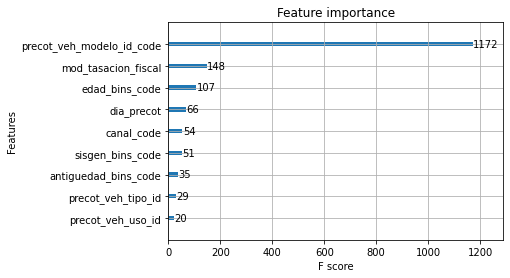

In [48]:
xgb.plot_importance(xgb_model )
plt.rcParams['figure.figsize'] = [6, 4]
plt.show();

### Predicciones del Modelo Ajustado

In [59]:
# Train Predict
y_train_pred_m2 = xgb_model.predict(X_train)
y_train_proba_m2 = xgb_model.predict_proba(X_train)

# Test Predict
y_test_pred_m2 = xgb_model.predict(X_test)
y_test_proba_m2 = xgb_model.predict_proba(X_test)

### Metrics Report Modelo Ajustado

----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.660762 
Recall: 0.491491 
F1: 0.563693
AUC:  0.6916737234041276

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,121297,14708
Falso,29640,28648


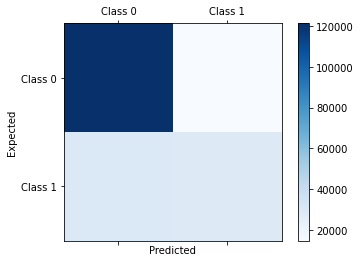


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.803627,0.660762,0.771747,0.732194,0.760767
recall,0.891857,0.491491,0.771747,0.691674,0.771747
f1-score,0.845446,0.563693,0.771747,0.704570,0.760920
support,136005.000000,58288.000000,0.771747,194293.000000,194293.000000



 ROC CURVE MODEL


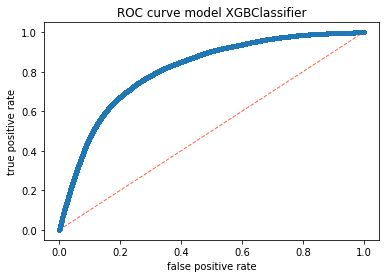


 PRECISION-RECALL CURVE


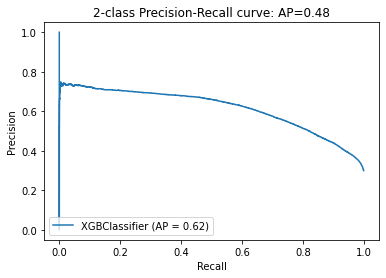


 TRADE-OFF PRECISION RECALL - TRAINING SET


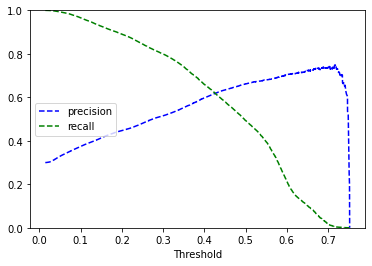


 
 ----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.438972 
Recall: 0.485609 
F1: 0.461114
AUC:  0.689955150815186

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,131177,15504
Falso,12850,12131


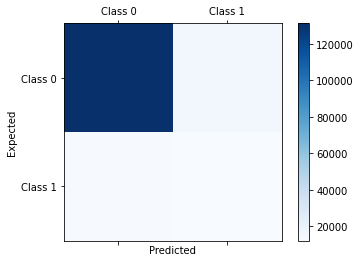


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.910781,0.438972,0.834827,0.674876,0.842121
recall,0.894301,0.485609,0.834827,0.689955,0.834827
f1-score,0.902466,0.461114,0.834827,0.681790,0.838238
support,146681.000000,24981.000000,0.834827,171662.000000,171662.000000



 ROC CURVE MODEL


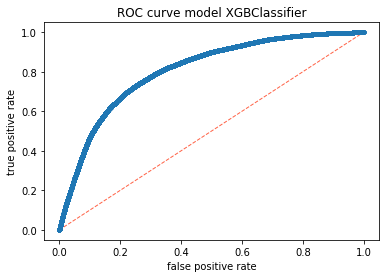


 PRECISION-RECALL CURVE


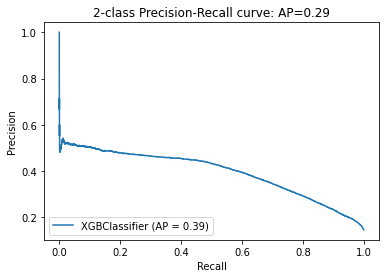


 TRADE-OFF PRECISION RECALL - TESTING SET


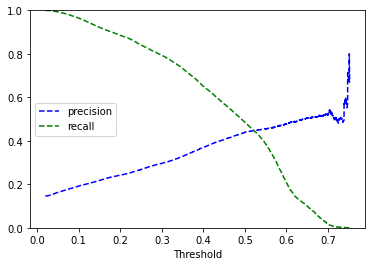

In [50]:
fxlib.metrics_report(xgb_model, X_train, y_train, X_test, y_test)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.653481 
Recall: 0.638223 
F1: 0.645762
AUC:  0.6748715944499942

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,40684,16495
Falso,17633,31107


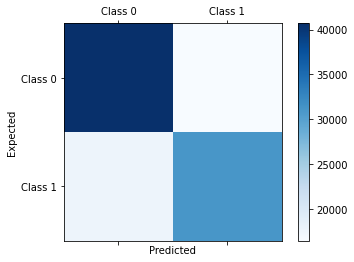


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.697635,0.653481,0.677792,0.675558,0.677317
recall,0.711520,0.638223,0.677792,0.674872,0.677792
f1-score,0.704509,0.645762,0.677792,0.675136,0.677476
support,57179.000000,48740.000000,0.677792,105919.000000,105919.000000



 ROC CURVE MODEL


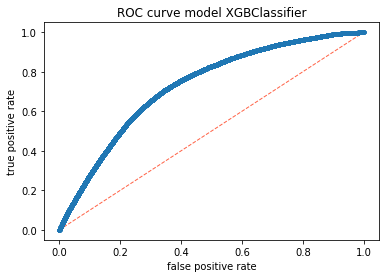


 PRECISION-RECALL CURVE


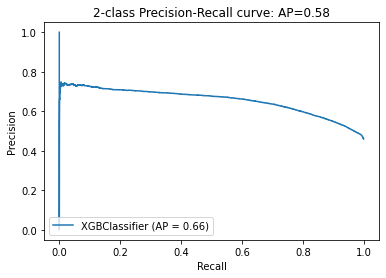


 TRADE-OFF PRECISION RECALL - TRAINING SET


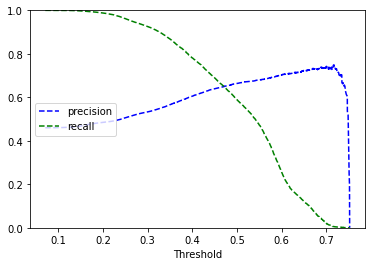


 
 ----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.441409 
Recall: 0.580174 
F1: 0.501367
AUC:  0.6656150139149245

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,46208,15316
Falso,8758,12103


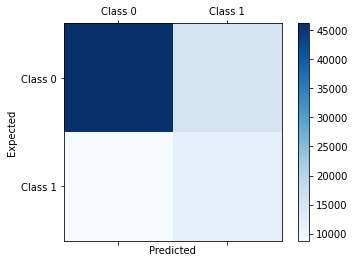


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.840665,0.441409,0.707787,0.641037,0.739568
recall,0.751056,0.580174,0.707787,0.665615,0.707787
f1-score,0.793338,0.501367,0.707787,0.647353,0.719407
support,61524.000000,20861.000000,0.707787,82385.000000,82385.000000



 ROC CURVE MODEL


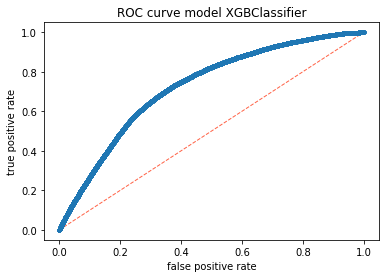


 PRECISION-RECALL CURVE


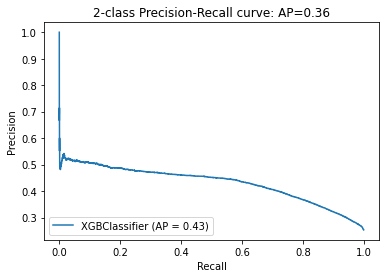


 TRADE-OFF PRECISION RECALL - TESTING SET


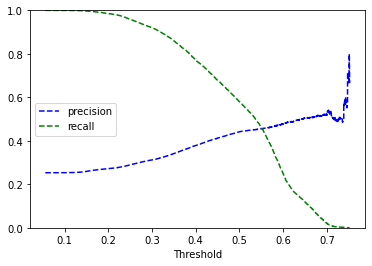

In [51]:
fxlib.canal_report(xgb_model, 1, X_train, y_train, X_test, y_test)

### Canal Directo

----------------------------------------------------------------------------
CANAL DIRECTO
----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,29056,0
Falso,6971,0


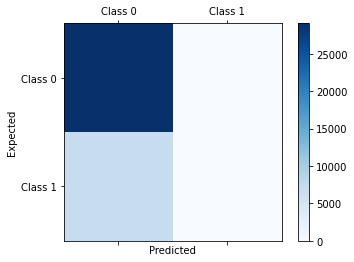


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.806506,0.0,0.806506,0.403253,0.650452
recall,1.000000,0.0,0.806506,0.500000,0.806506
f1-score,0.892891,0.0,0.806506,0.446445,0.720122
support,29056.000000,6971.0,0.806506,36027.000000,36027.000000



 ROC CURVE MODEL


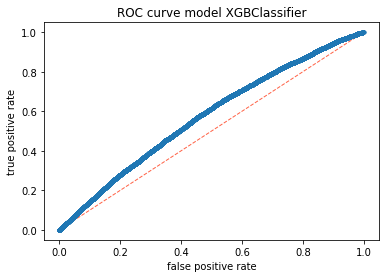


 PRECISION-RECALL CURVE


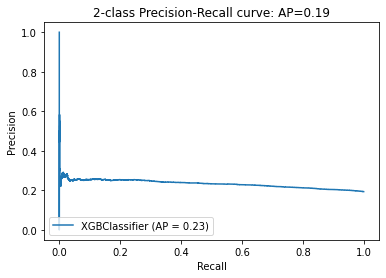


 TRADE-OFF PRECISION RECALL - TRAINING SET


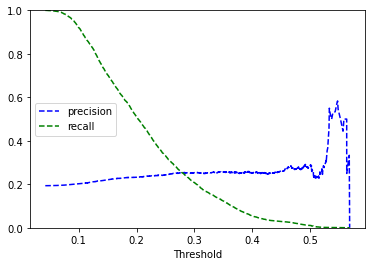


 
 ----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.129630 
Recall: 0.009315 
F1: 0.017381
AUC:  0.501652621109909

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,31096,188
Falso,2978,28


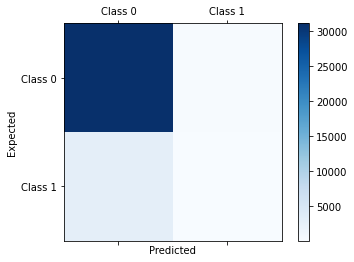


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.912602,0.129630,0.90767,0.521116,0.843963
recall,0.993991,0.009315,0.90767,0.501653,0.907670
f1-score,0.951559,0.017381,0.90767,0.484470,0.869665
support,31284.000000,3006.000000,0.90767,34290.000000,34290.000000



 ROC CURVE MODEL


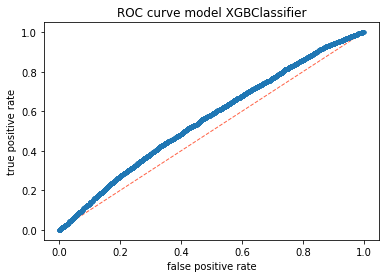


 PRECISION-RECALL CURVE


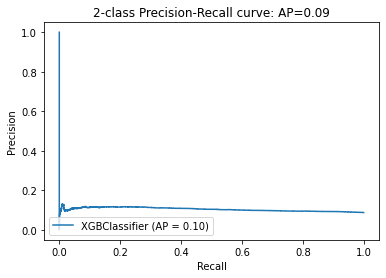


 TRADE-OFF PRECISION RECALL - TESTING SET


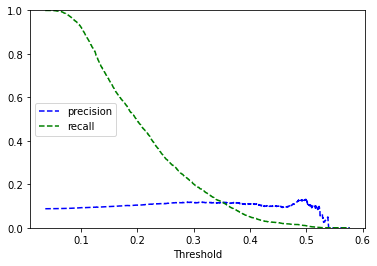

In [52]:
fxlib.canal_report(xgb_model, 2, X_train, y_train, X_test, y_test)

### Canal Masivos

----------------------------------------------------------------------------
CANAL MASIVOS
----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,32960,0
Falso,1004,0


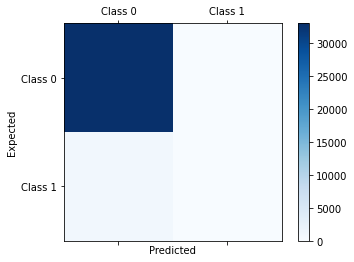


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.970439,0.0,0.970439,0.485220,0.941752
recall,1.000000,0.0,0.970439,0.500000,0.970439
f1-score,0.984998,0.0,0.970439,0.492499,0.955881
support,32960.000000,1004.0,0.970439,33964.000000,33964.000000



 ROC CURVE MODEL


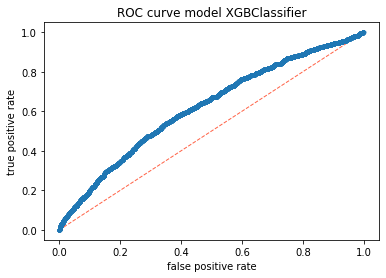


 PRECISION-RECALL CURVE


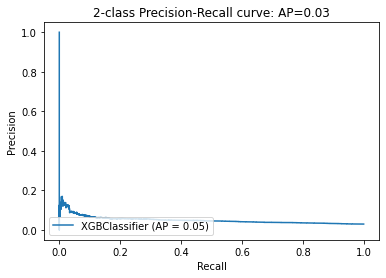


 TRADE-OFF PRECISION RECALL - TRAINING SET


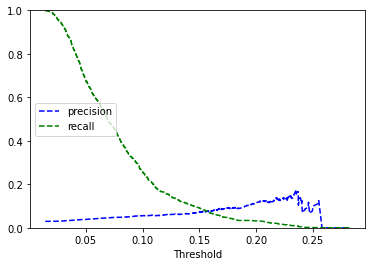


 
 ----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,35545,0
Falso,454,0


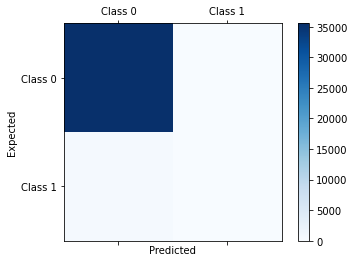


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.987389,0.0,0.987389,0.493694,0.974936
recall,1.000000,0.0,0.987389,0.500000,0.987389
f1-score,0.993654,0.0,0.987389,0.496827,0.981123
support,35545.000000,454.0,0.987389,35999.000000,35999.000000



 ROC CURVE MODEL


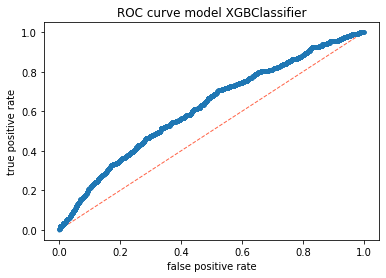


 PRECISION-RECALL CURVE


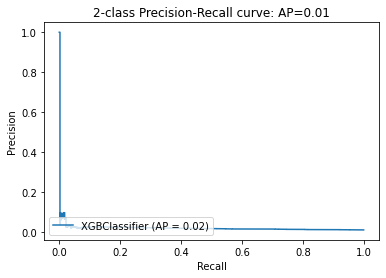


 TRADE-OFF PRECISION RECALL - TESTING SET


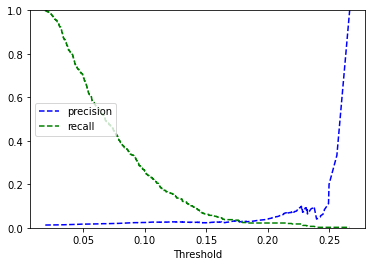

In [53]:
fxlib.canal_report(xgb_model, 3, X_train, y_train, X_test, y_test)

### Canal Corredor

----------------------------------------------------------------------------
CANAL CORREDOR
----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,16810,0
Falso,1573,0


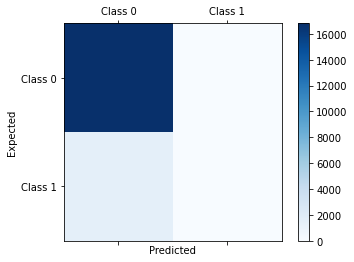


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.914432,0.0,0.914432,0.457216,0.836186
recall,1.000000,0.0,0.914432,0.500000,0.914432
f1-score,0.955304,0.0,0.914432,0.477652,0.873560
support,16810.000000,1573.0,0.914432,18383.000000,18383.000000



 ROC CURVE MODEL


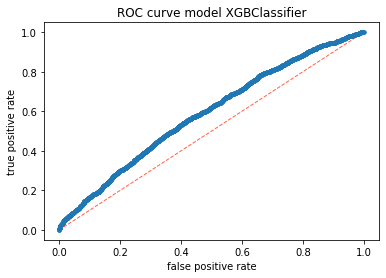


 PRECISION-RECALL CURVE


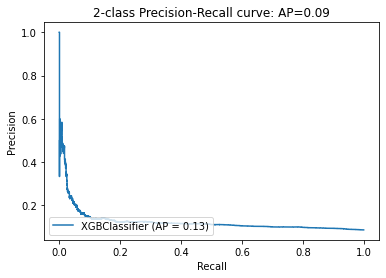


 TRADE-OFF PRECISION RECALL - TRAINING SET


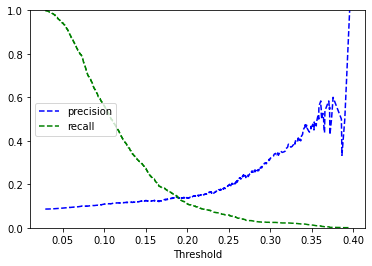


 
 ----------------------------------------------------------------------------
Metrics Report Model XGBClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,18328,0
Falso,660,0


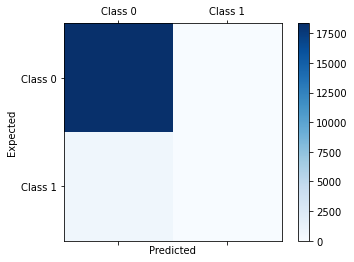


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.965241,0.0,0.965241,0.482621,0.931691
recall,1.000000,0.0,0.965241,0.500000,0.965241
f1-score,0.982313,0.0,0.965241,0.491157,0.948169
support,18328.000000,660.0,0.965241,18988.000000,18988.000000



 ROC CURVE MODEL


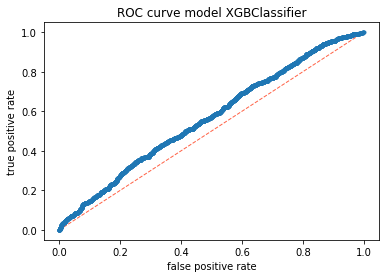


 PRECISION-RECALL CURVE


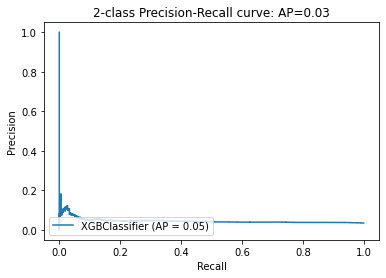


 TRADE-OFF PRECISION RECALL - TESTING SET


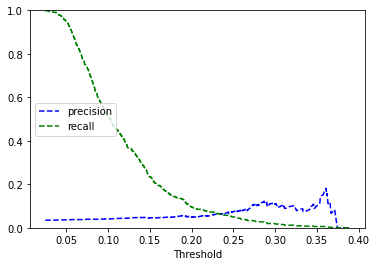

In [54]:
fxlib.canal_report(xgb_model, 4, X_train, y_train, X_test, y_test)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.674872,0.50000,0.50000,0.50000
Accuracy,0.677790,0.80651,0.97044,0.91443
Presicion,0.675560,0.40325,0.48522,0.45722
Recall,0.674870,0.50000,0.50000,0.50000
F1,0.675140,0.44645,0.49250,0.47765


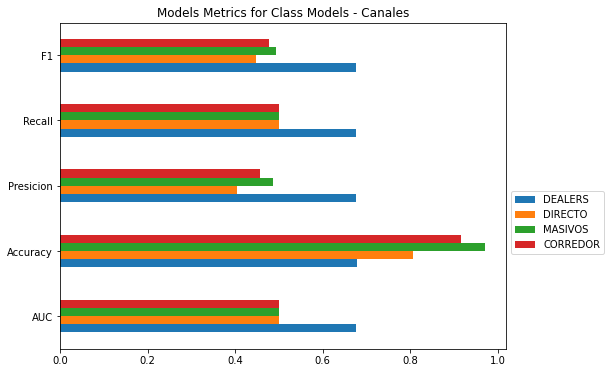

In [55]:
fxlib.canal_comparison(xgb_model, X_train, y_train)

### Comparación Test dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.514043,0.50000,0.50000,0.50000
Accuracy,0.747250,0.91234,0.98739,0.96524
Presicion,0.631710,0.45617,0.49369,0.48262
Recall,0.514040,0.50000,0.50000,0.50000
F1,0.465230,0.47708,0.49683,0.49116


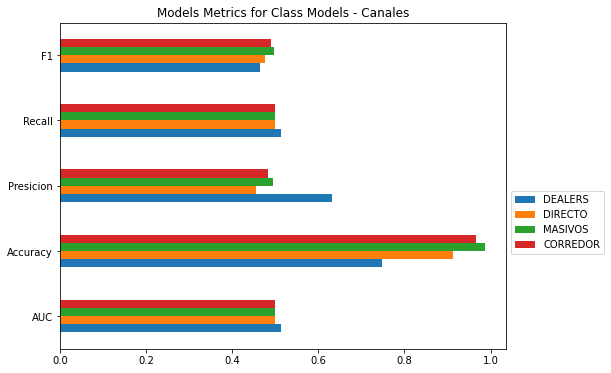

In [56]:
fxlib.canal_comparison(xgb_model, X_test, y_test)

# Random Forest Clasiffier

### Diseño del espacio Parametrico

````python
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
         'max_depth': hp.quniform('max_depth', 10, 1200, 10),
         'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
         'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
         'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
         'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200]),
         'bootstrap': hp.choice('bootstrap', [True, False])}
````         

### Definición de la Función Objetivo a Optimizar

````python
def objective(space):
    clf = RandomForestClassifier(criterion = space['criterion'], 
                                 max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'],
                                 bootstrap = space['bootstrap'])
    
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred>0.5, average='binary')
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }
````    

### Optimización Bayesiana de Hyperparametros

```python
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)                        
```

### Ajuste del modelo optimo

```python
rf_clf = RandomForestClassifier(criterion = 'gini',
                                n_estimators=int(best_hyperparams['n_estimators']),
                                max_features=int(best_hyperparams['max_features']),
                                min_samples_split=best_hyperparams['min_samples_split'],
                                min_samples_leaf=best_hyperparams['min_samples_leaf'],
                                bootstrap=False,
                                max_depth=int(best_hyperparams['max_depth']),
                                random_state = 16626).fit(X_train, y_train)
```                                

### Serializacion del modelo

```python
# Serialización del modelo
pickle.dump(rf_clf, open('rf_clf_model.pkl','wb'))
 
# Copia del modelo serializado a carpeta drive
!cp /tmp/data_clusters/rf_clf_model.pkl /gdrive/My\ Drive/Proyecto_Nuevos_Clusters
```

In [ ]:
# Copia del archivo a directorio local
!cp /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/rf_clf_model.pkl /tmp/data_clusters

# importación modelo
rf_clf = pickle.load(open('rf_clf_model.pkl', 'rb'))

### Features Importances

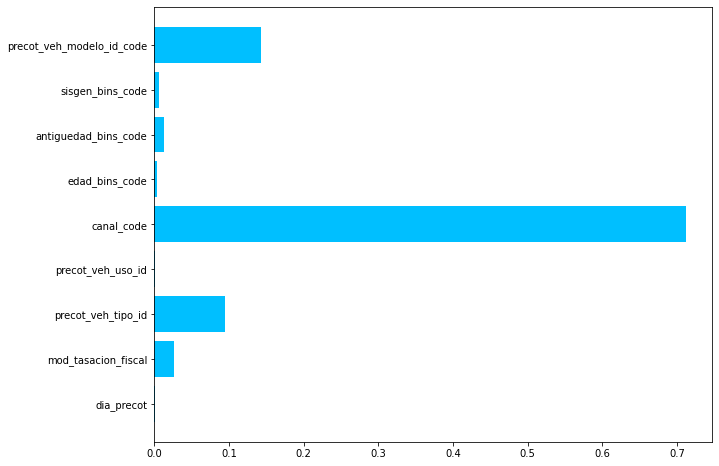

In [118]:
fxlib.features_importances_plot(rf_clf, X_train.columns)

### Predicciones del Modelo Ajustado

In [39]:
# Train Predict
y_train_pred_m3 = rf_clf.predict(X_train)
y_train_proba_m3 = rf_clf.predict_proba(X_train)

# Test Predict
y_test_pred_m3 = rf_clf.predict(X_test)
y_test_proba_m3 = rf_clf.predict_proba(X_test)

### Metrics Report del Modelo Ajustado

----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.622510 
Recall: 0.544280 
F1: 0.580773
AUC:  0.701414722154668

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,116767,19238
Falso,26563,31725


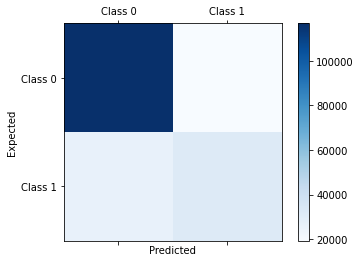


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.814672,0.622510,0.764268,0.718591,0.757024
recall,0.858549,0.544280,0.764268,0.701415,0.764268
f1-score,0.836036,0.580773,0.764268,0.708404,0.759457
support,136005.000000,58288.000000,0.764268,194293.000000,194293.000000



 ROC CURVE MODEL


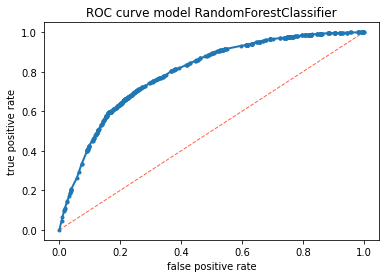


 PRECISION-RECALL CURVE


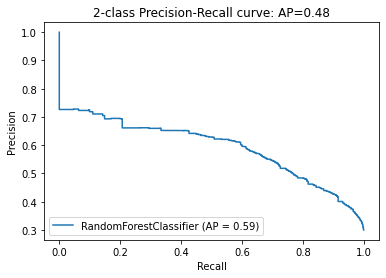


 TRADE-OFF PRECISION RECALL - TRAINING SET


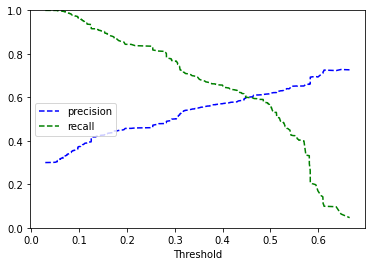


 
 ----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.395100 
Recall: 0.549418 
F1: 0.459653
AUC:  0.7030805514303619

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,125668,21013
Falso,11256,13725


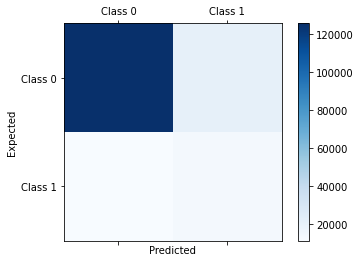


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.917794,0.395100,0.81202,0.656447,0.841729
recall,0.856744,0.549418,0.81202,0.703081,0.812020
f1-score,0.886219,0.459653,0.81202,0.672936,0.824143
support,146681.000000,24981.000000,0.81202,171662.000000,171662.000000



 ROC CURVE MODEL


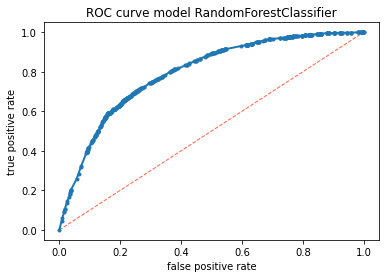


 PRECISION-RECALL CURVE


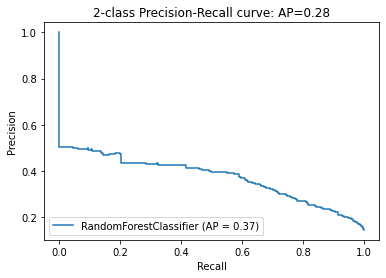


 TRADE-OFF PRECISION RECALL - TESTING SET


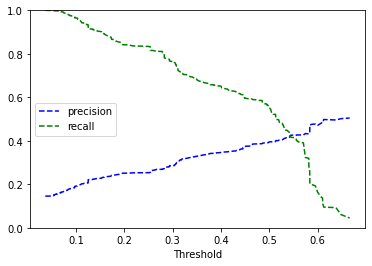

In [42]:
fxlib.metrics_report(rf_clf, X_train, y_train, X_test, y_test)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.623980 
Recall: 0.624518 
F1: 0.624249
AUC:  0.6520804345657124

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,38915,18343
Falso,18301,30439


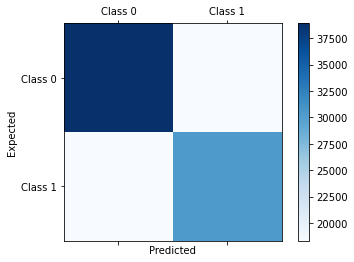


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.680142,0.623980,0.654295,0.652061,0.654318
recall,0.679643,0.624518,0.654295,0.652080,0.654295
f1-score,0.679892,0.624249,0.654295,0.652071,0.654306
support,57258.000000,48740.000000,0.654295,105998.000000,105998.000000



 ROC CURVE MODEL


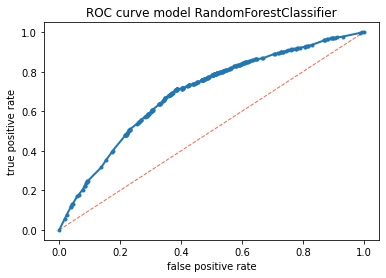


 PRECISION-RECALL CURVE


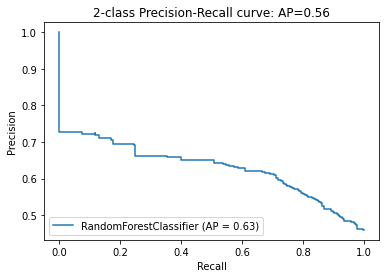


 TRADE-OFF PRECISION RECALL - TRAINING SET


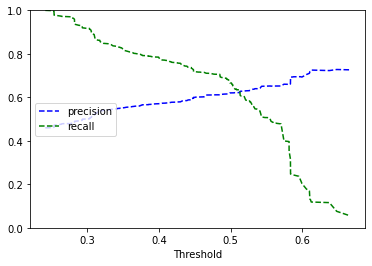


 
 ----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.395100 
Recall: 0.657926 
F1: 0.493714
AUC:  0.6581923808264349

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,40511,21013
Falso,7136,13725


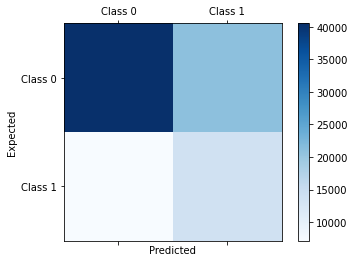


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.850232,0.395100,0.658324,0.622666,0.734986
recall,0.658458,0.657926,0.658324,0.658192,0.658324
f1-score,0.742157,0.493714,0.658324,0.617935,0.679248
support,61524.000000,20861.000000,0.658324,82385.000000,82385.000000



 ROC CURVE MODEL


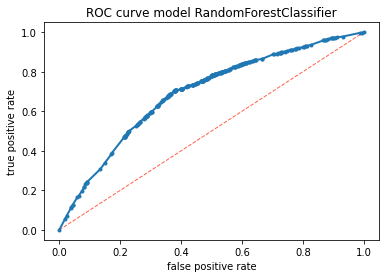


 PRECISION-RECALL CURVE


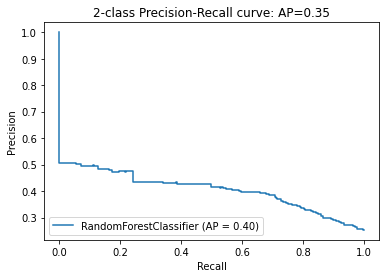


 TRADE-OFF PRECISION RECALL - TESTING SET


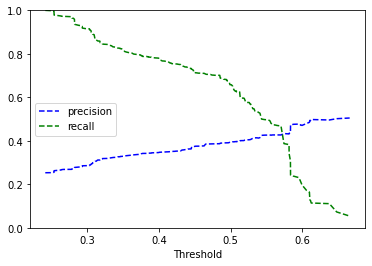

In [43]:
fxlib.canal_report(rf_clf, 1, X_train, y_train, X_test, y_test)

### Canal Directo

----------------------------------------------------------------------------
CANAL DIRECTO
----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,29113,0
Falso,6971,0


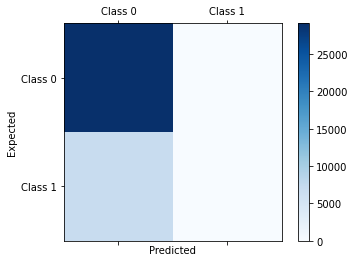


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.806812,0.0,0.806812,0.403406,0.650945
recall,1.000000,0.0,0.806812,0.500000,0.806812
f1-score,0.893078,0.0,0.806812,0.446539,0.720546
support,29113.000000,6971.0,0.806812,36084.000000,36084.000000



 ROC CURVE MODEL


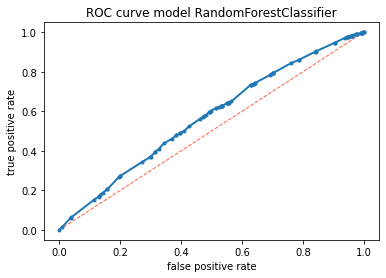


 PRECISION-RECALL CURVE


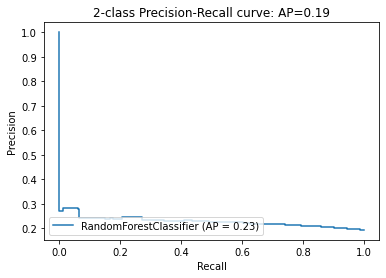


 TRADE-OFF PRECISION RECALL - TRAINING SET


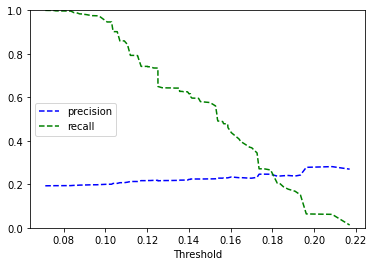


 
 ----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,31284,0
Falso,3006,0


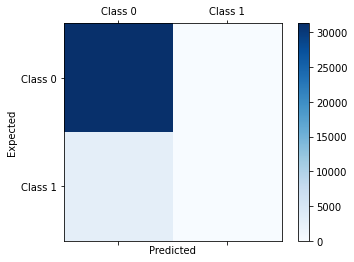


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.912336,0.0,0.912336,0.456168,0.832357
recall,1.000000,0.0,0.912336,0.500000,0.912336
f1-score,0.954159,0.0,0.912336,0.477079,0.870513
support,31284.000000,3006.0,0.912336,34290.000000,34290.000000



 ROC CURVE MODEL


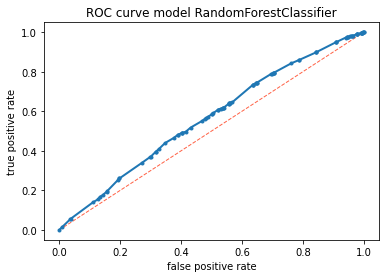


 PRECISION-RECALL CURVE


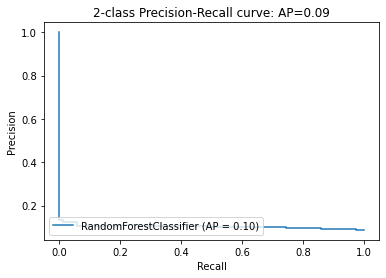


 TRADE-OFF PRECISION RECALL - TESTING SET


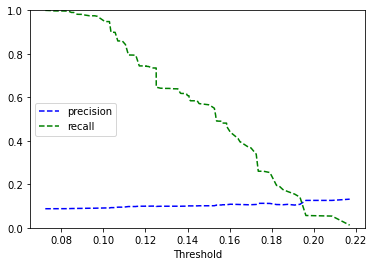

In [44]:
fxlib.canal_report(rf_clf, 2, X_train, y_train, X_test, y_test)

### Canal Masivos

----------------------------------------------------------------------------
CANAL MASIVOS
----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,32723,0
Falso,1004,0


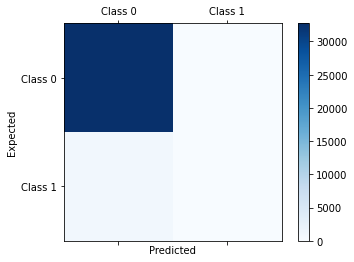


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.970232,0.0,0.970232,0.485116,0.941349
recall,1.000000,0.0,0.970232,0.500000,0.970232
f1-score,0.984891,0.0,0.970232,0.492445,0.955572
support,32723.000000,1004.0,0.970232,33727.000000,33727.000000



 ROC CURVE MODEL


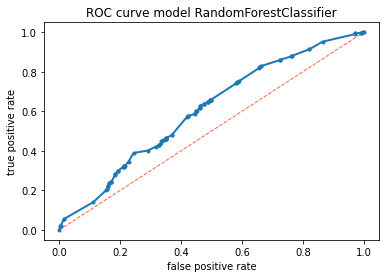


 PRECISION-RECALL CURVE


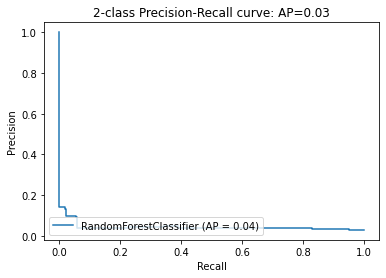


 TRADE-OFF PRECISION RECALL - TRAINING SET


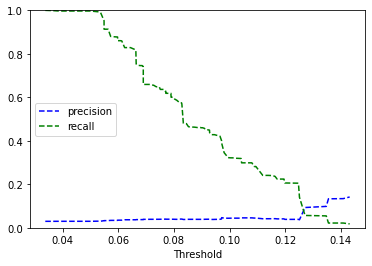


 
 ----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,35545,0
Falso,454,0


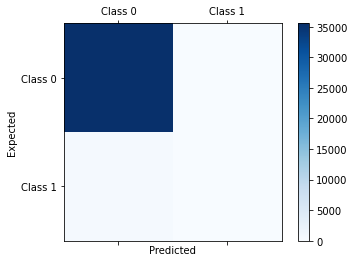


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.987389,0.0,0.987389,0.493694,0.974936
recall,1.000000,0.0,0.987389,0.500000,0.987389
f1-score,0.993654,0.0,0.987389,0.496827,0.981123
support,35545.000000,454.0,0.987389,35999.000000,35999.000000



 ROC CURVE MODEL


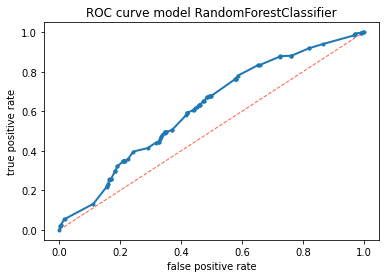


 PRECISION-RECALL CURVE


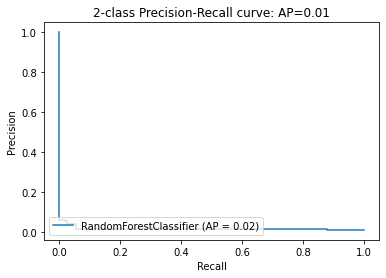


 TRADE-OFF PRECISION RECALL - TESTING SET


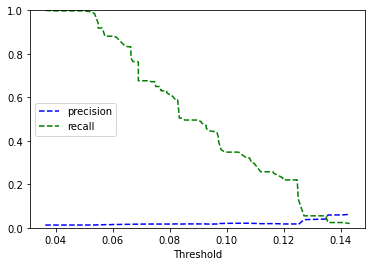

In [45]:
fxlib.canal_report(rf_clf, 3, X_train, y_train, X_test, y_test)

### Canal Corredor

----------------------------------------------------------------------------
CANAL CORREDOR
----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,16911,0
Falso,1573,0


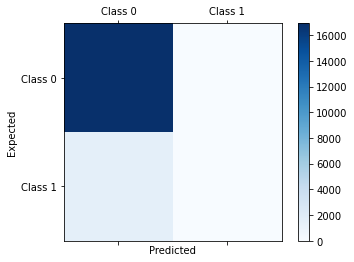


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.914899,0.0,0.914899,0.457450,0.837041
recall,1.000000,0.0,0.914899,0.500000,0.914899
f1-score,0.955559,0.0,0.914899,0.477779,0.874240
support,16911.000000,1573.0,0.914899,18484.000000,18484.000000



 ROC CURVE MODEL


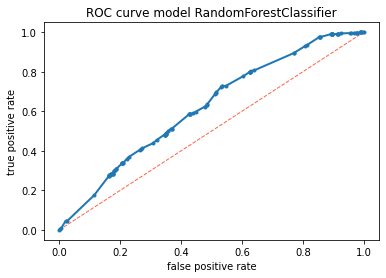


 PRECISION-RECALL CURVE


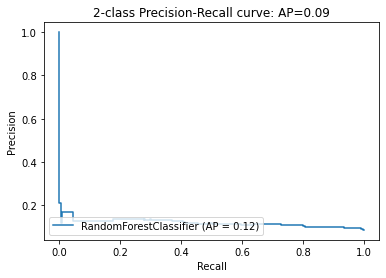


 TRADE-OFF PRECISION RECALL - TRAINING SET


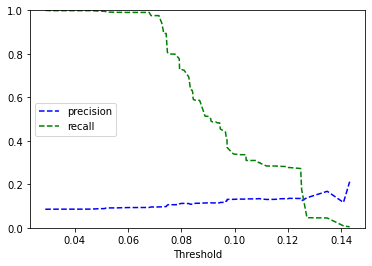


 
 ----------------------------------------------------------------------------
Metrics Report Model RandomForestClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.000000 
Recall: 0.000000 
F1: 0.000000
AUC:  0.5

 CONFUSION MATRIX


,Verdadero,Falso
Verdadero,18328,0
Falso,660,0


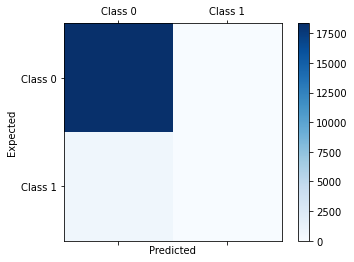


 METRICS MODEL


,0,1,accuracy,macro avg,weighted avg
precision,0.965241,0.0,0.965241,0.482621,0.931691
recall,1.000000,0.0,0.965241,0.500000,0.965241
f1-score,0.982313,0.0,0.965241,0.491157,0.948169
support,18328.000000,660.0,0.965241,18988.000000,18988.000000



 ROC CURVE MODEL


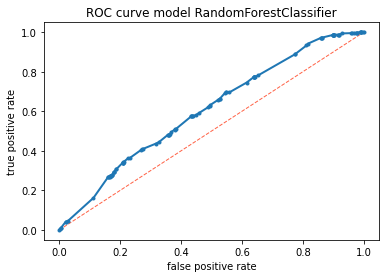


 PRECISION-RECALL CURVE


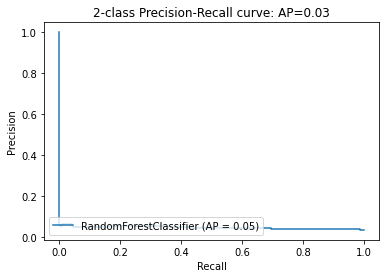


 TRADE-OFF PRECISION RECALL - TESTING SET


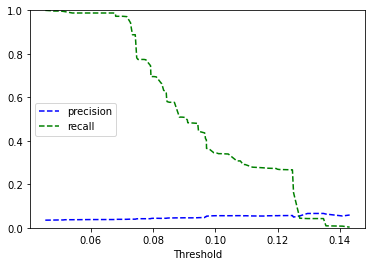

In [46]:
fxlib.canal_report(rf_clf, 4, X_train, y_train, X_test, y_test)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.65208,0.50000,0.50000,0.50000
Accuracy,0.65430,0.80681,0.97023,0.91490
Presicion,0.65206,0.40341,0.48512,0.45745
Recall,0.65208,0.50000,0.50000,0.50000
F1,0.65207,0.44654,0.49245,0.47778


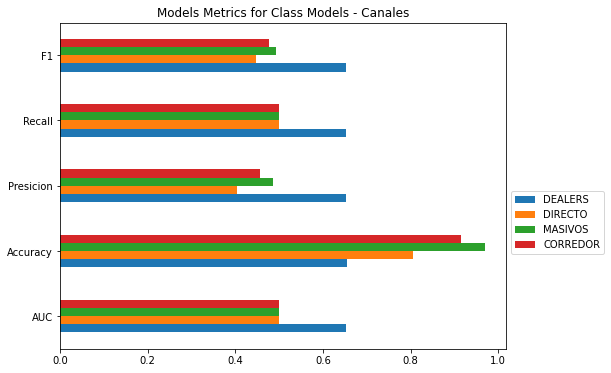

In [47]:
fxlib.canal_comparison(rf_clf, X_train, y_train)

### Comparación Test dataset

Metrics Comparison - Canales


,DEALERS,DIRECTO,MASIVOS,CORREDOR
AUC,0.50000,0.50000,0.50000,0.50000
Accuracy,0.74679,0.91234,0.98739,0.96524
Presicion,0.37339,0.45617,0.49369,0.48262
Recall,0.50000,0.50000,0.50000,0.50000
F1,0.42752,0.47708,0.49683,0.49116


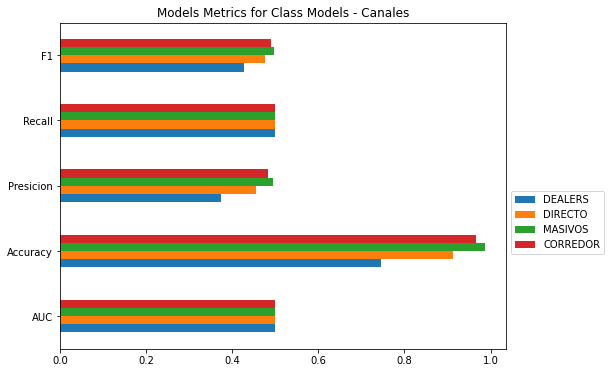

In [48]:
fxlib.canal_comparison(rf_clf, X_test, y_test)

# Comparación de desempeño por Modelo

### Comparación Train Dataset

Metrics Comparison


,Model_DecisionTreeClassifier1,Model_XGBClassifier2,Model_RandomForestClassifier3
AUC,0.715674,0.692756,0.705416
Accuracy,0.774230,0.772410,0.764820
Presicion,0.731240,0.733050,0.719210
Recall,0.715670,0.692760,0.705420
F1,0.722240,0.705650,0.711260


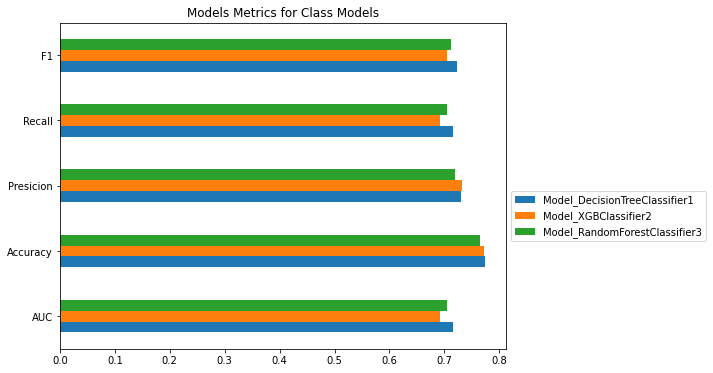

In [60]:
model_list = [dec_tree, xgb_model,rf_clf]
auc_list = [roc_auc_score(y_train, y_train_pred), 
            roc_auc_score(y_train, y_train_pred_m2),
            roc_auc_score(y_train, y_train_pred_m3)]
metrics_list = [pd.DataFrame(classification_report(y_train, y_train_pred, output_dict = True)),
                pd.DataFrame(classification_report(y_train, y_train_pred_m2, output_dict = True)),
                pd.DataFrame(classification_report(y_train, y_train_pred_m3, output_dict = True))]
y_pred_list = [y_train_pred, y_train_pred_m2, y_train_pred_m3]
y_train_list = [y_train, y_train, y_train]

fxlib.metrics_comparative(model_list, auc_list, metrics_list, y_train_list, y_pred_list)

### Comparación Dataset de Pruebas

Metrics Comparison


,Model_DecisionTreeClassifier1,Model_XGBClassifier2,Model_RandomForestClassifier3
AUC,0.711634,0.689955,0.703081
Accuracy,0.820930,0.834830,0.812020
Presicion,0.667130,0.674880,0.656450
Recall,0.711630,0.689960,0.703080
F1,0.683700,0.681790,0.672940


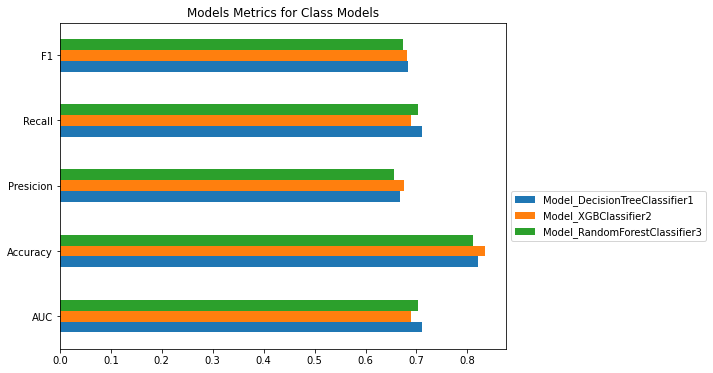

In [61]:
model_list = [dec_tree, xgb_model, rf_clf]
auc_list = [roc_auc_score(y_test, y_test_pred), 
            roc_auc_score(y_test, y_test_pred_m2),
            roc_auc_score(y_test, y_test_pred_m3)]
metrics_list = [pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True)),
                pd.DataFrame(classification_report(y_test, y_test_pred_m2, output_dict = True)),
                pd.DataFrame(classification_report(y_test, y_test_pred_m3, output_dict = True))]
y_pred_list = [y_test_pred, y_test_pred_m2, y_test_pred_m3]
y_train_list = [y_test, y_test, y_test]

fxlib.metrics_comparative(model_list, auc_list, metrics_list, y_train_list, y_pred_list)

# Desicion Tree Classifier Model Export

In [159]:
r = export_text(dec_tree, feature_names=list(X_train.columns))
pickle.dump(r, open('dec_tree_model.txt','wb'))
!cp /tmp/data_clusters/dec_tree_model.txt /gdrive/My\ Drive/Proyecto_Nuevos_Clusters

In [160]:
print(r)

|--- canal_code <= 1.50
|   |--- precot_veh_tipo_id <= 1.50
|   |   |--- precot_veh_modelo_id_code <= 869.50
|   |   |   |--- precot_veh_modelo_id_code <= 282.00
|   |   |   |   |--- antiguedad_veh <= 0.50
|   |   |   |   |   |--- mod_tasacion_fiscal <= 7.50
|   |   |   |   |   |   |--- sisgen_usar <= 1.09
|   |   |   |   |   |   |   |--- precot_veh_modelo_id_code <= 199.50
|   |   |   |   |   |   |   |   |--- mod_tasacion_fiscal <= 6.50
|   |   |   |   |   |   |   |   |   |--- dia_precot <= 21.50
|   |   |   |   |   |   |   |   |   |   |--- dia_precot <= 14.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- dia_precot >  14.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- dia_precot >  21.50
|   |   |   |   |   |   |   |   |   |   |--- dia_precot <= 25.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- dia_precot >  25.50
| 